Code for only running autoencoder 
#### changelog 
+ v2- successfully runnig N iterations across all combinations
+ v3- adding WT CLNZ and streamlinecode. created N indepdenent bootstrap run code to evaluate staiblity of results. packaged resample function

In [1]:
%pip install -r autoencoder_cloud_requirements.txt
%matplotlib inline
import sys
import os
import logging #to suppress pytorch GPU output etc
import warnings
#supress specific future warnings and automatic lighitning outputs
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)
logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.WARNING)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore",r".*does not have many workers which may be a bottleneck.*")
warnings.filterwarnings("ignore",".*GPU available.*",category=UserWarning) # option 2: just filter out the GPU‐warning
#run import modules for analysis 
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import itertools
from tqdm import tqdm
import datetime
import pickle
import sklearn
from sklearn.metrics import davies_bouldin_score
print(f"matplotlib version: {matplotlib.__version__},sns version: {sns.__version__},pandas ver: {pd.__version__}")
#torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightning as L
from torch.utils.data import TensorDataset, DataLoader
import tensorboard
from functools import partial
from joblib import Parallel, delayed 
#custom loads
from external_functions import *
from sns_plotting_config import *
from ax_modifier_functions_cloud import *
plt.style.use('paper_plot.mplstyle') ## elsevier fig sizes https://www.elsevier.com/about/policies-and-standards/author/artwork-and-media-instructions/artwork-sizing

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
matplotlib version: 3.7.0,sns version: 0.12.1,pandas ver: 1.5.2


<Figure size 640x480 with 0 Axes>

In [2]:
# Define the relative path to the src directory
module_path = r'G:\My Drive\Colab notebooks\Function .py Storage\plot_posthoc_test\src\plot_posthoc_test'
function_dir =  os.path.join(r'G:\\My Drive\\Colab notebooks\\', 'Function .py Storage')
print(function_dir)
if module_path not in sys.path:
    sys.path.append(module_path)
if function_dir not in sys.path:
    sys.path.append(function_dir)
# Import functions and classes from plot_stat_annotate
from plot_stat_annotate import *



G:\\My Drive\\Colab notebooks\\Function .py Storage


<Figure size 960x720 with 0 Axes>

In [3]:
print(os.getcwd())

G:\My Drive\Colab notebooks\lightning_autoencoder


## Process Data 


#### Create dataset object for resampling in bootstrapabs

In [4]:
folder_loc = '/Run Outputs/'
date_tag = "_".join([datetime.now().strftime('%d'),datetime.now().strftime('%h'),datetime.now().strftime('%Y')])
print(f"date tag: {date_tag}")
folder_name =folder_loc+  f"figure_5_postSVM_decoding_accuracy_and_PCA_plots_"+ date_tag + "/"

date tag: 12_Jul_2025


In [5]:
# new folder structure:
# outputs/                     # For trained models and results
# │   ├── models/                  # Trained model checkpoints
# │   ├── figures/                 # Generated figures
# │   └── logs/                    # Lightning logs
    
data_folder = os.getcwd() +"/data/"
output_folder = os.getcwd() +"/output/"
model_results_folder = output_folder + "/model_results/"
current_run_output = model_results_folder + f"{date_tag}\\"
all_figure_output_folder = output_folder +"/figures/"
fig_output = all_figure_output_folder + f"{date_tag}\\"
#make folders 
make_folder(output_folder)
make_folder(all_figure_output_folder)
make_folder(fig_output)
make_folder(model_results_folder)
make_folder(current_run_output)

The folder 'G:\My Drive\Colab notebooks\lightning_autoencoder/output/' already exists.
The folder 'G:\My Drive\Colab notebooks\lightning_autoencoder/output//figures/' already exists.
The folder 'G:\My Drive\Colab notebooks\lightning_autoencoder/output//figures/12_Jul_2025\' has been created.
The folder 'G:\My Drive\Colab notebooks\lightning_autoencoder/output//model_results/' already exists.
The folder 'G:\My Drive\Colab notebooks\lightning_autoencoder/output//model_results/12_Jul_2025\' has been created.


In [6]:
#declare loc/names of files to read
timeseries_loc=data_folder
load_dataset = True
save_norm_trial_dataset = True
trial_df_filename = timeseries_loc +  f"Dlx56_Normalized Trial Calcium Timeseries_20_Jun_2025.parquet"

if load_dataset:
    print(f"loading_dataset")
    trial_tseries_df_norm = pd.read_parquet(trial_df_filename)
else:
    trial_tseries_df_norm = get_normed_trial_tseries(enriched_by_stage_path,post_activity_timeseries, hyper_param_dict) #OPTIONAL- drop  timebins #drop N bins if applicable
    if save_norm_trial_dataset:
        print(f"saving {trial_df_filename}")
        trial_tseries_df_norm.to_parquet(trial_df_filename)
trial_tseries_df_norm.tail()

loading_dataset


,task_phase_vec,IA_RS_vec,corr_err_vec,trial_num,neuron_ID,name,day,geno,geno_day,-3.0s to -2.75s,...,Late_IA,Early_RS_Error,Early_RS_Correct,Late_RS,enriched_in_phase,any_enrichment,unique_ID,max_trial_val,mean_rate,active_in_trial
116370,Late_RS,RS,Correct,38,209,9_3_HET_RS3,3,HET,Het postCLNZ,0.0,...,0.0,0.0,0.0,0.0,False,1.0,9_3_HET_RS3-209,1.0,0.02,True
116373,Late_RS,RS,Correct,38,212,9_3_HET_RS3,3,HET,Het postCLNZ,0.0,...,0.0,0.0,0.0,0.0,False,2.0,9_3_HET_RS3-212,1.0,0.03,True
116374,Late_RS,RS,Correct,38,213,9_3_HET_RS3,3,HET,Het postCLNZ,0.0,...,0.0,0.0,0.0,0.0,False,0.0,9_3_HET_RS3-213,1.0,0.00,False
116375,Late_RS,RS,Correct,38,214,9_3_HET_RS3,3,HET,Het postCLNZ,0.0,...,0.0,0.0,0.0,0.0,False,0.0,9_3_HET_RS3-214,1.0,0.20,True
116376,Late_RS,RS,Correct,38,215,9_3_HET_RS3,3,HET,Het postCLNZ,0.0,...,0.0,0.0,0.0,0.0,False,0.0,9_3_HET_RS3-215,0.8,0.00,False


In [7]:
#once loaded, derive info from metadata
stage_names = sorted(trial_tseries_df_norm['task_phase_vec'].unique())#hardcode the stage_names (to not rely on the order of the 'unique() vector of the df
numeric_col = get_numeric_cols_timeseries(trial_tseries_df_norm, " to ") #in external_functions.py
# note informative stats for refernce later if necessary
subject_stage_info_df = get_subject_stage_info_df(trial_tseries_df_norm) # get subj level dfs
n_total_units = trial_tseries_df_norm.groupby(by = 'geno_day')['unique_ID'].nunique()
print(n_total_units)
subject_stage_info_df.tail()

geno_day
Het CLNZ         866
Het VEH          874
Het postCLNZ     937
WT CLNZ         1019
WT VEH          1080
Name: unique_ID, dtype: int64


,name,geno_day,task_phase_vec,unique_ID,num_enriched_units,num_units,trial_num,count_of_trials,over_5
198,9_3_HET_RS3,Het postCLNZ,Early_IA_Error,"[9_3_HET_RS3-6, 9_3_HET_RS3-9, 9_3_HET_RS3-12,...",34,179,"[3, 5]",2,"[False, False]"
199,9_3_HET_RS3,Het postCLNZ,Early_RS_Correct,"[9_3_HET_RS3-40, 9_3_HET_RS3-62, 9_3_HET_RS3-7...",9,179,"[17, 19, 21]",3,"[True, True, True]"
200,9_3_HET_RS3,Het postCLNZ,Early_RS_Error,"[9_3_HET_RS3-25, 9_3_HET_RS3-45, 9_3_HET_RS3-6...",9,179,"[18, 20]",2,"[True, True]"
201,9_3_HET_RS3,Het postCLNZ,Late_IA,"[9_3_HET_RS3-9, 9_3_HET_RS3-25, 9_3_HET_RS3-31...",15,179,"[12, 13, 14, 15, 16]",5,"[True, True, True, True, True]"
202,9_3_HET_RS3,Het postCLNZ,Late_RS,"[9_3_HET_RS3-3, 9_3_HET_RS3-130]",2,179,"[34, 35, 36, 38]",4,"[True, True, True, True]"


#### save class matrix store for loading later

In [8]:
# save store class_matrix_store
class_matrix_save_file = f"pseudopopulation_ensemble_activity_store_{date_tag}"
load_filename = data_folder + f"pseudopopulation_ensemble_activity_store_20_Jun_2025.pickle"

make_class_matrix = False
save_class_matrix = False

if make_class_matrix: ##create class matrix store
    neuron_enrichment =  trial_tseries_df_norm.groupby(['name', 'geno_day', 'neuron_ID'])[stage_names].mean().reset_index()
    phase_enrichment_by_subj = neuron_enrichment[list(stage_names) + ['name', 'geno_day']].groupby(by = ['name', 'geno_day']).sum().reset_index()
    trial_list_by_dataset= subject_stage_info_df.loc[:,['name', 'geno_day', 'task_phase_vec', 'trial_num', 'count_of_trials']]
    trial_list_by_dataset= trial_list_by_dataset[trial_list_by_dataset.count_of_trials >1]##important- threshold to take datasets with >1 trials per section (to have enough variety in neural activity)
    enrich_unit_ID_by_name_df = subject_stage_info_df.loc[:,['name', 'geno_day', 'task_phase_vec', 'unique_ID']]
    dataset_name_by_geno_day = enrich_unit_ID_by_name_df.groupby('geno_day')['name'].unique().reset_index()
    #use premade information to create new matrix
    class_matrix_store = make_dataset_matrix_store_only(stage_names, trial_tseries_df_norm, "unique_ID",
                                                enrich_unit_ID_by_name_df, 
                                                numeric_col,
                                                trial_list_by_dataset,
                                                dataset_name_by_geno_day,
                                                phase_enrichment_by_subj)
    if save_class_matrix:
        with open(class_matrix_save_file+'.pickle', 'wb') as handle:
            pickle.dump(class_matrix_store, handle, protocol=pickle.HIGHEST_PROTOCOL)
else: #if you don't make or save one, you load one 
    print(f" loading file: {load_filename}")
    with open(load_filename, 'rb') as handle:
        class_matrix_store = pickle.load(handle)

 loading file: G:\My Drive\Colab notebooks\lightning_autoencoder/data/pseudopopulation_ensemble_activity_store_20_Jun_2025.pickle


In [9]:
class_matrix_store.keys()

dict_keys(['Early_IA_Correct', 'Early_IA_Error', 'Early_RS_Correct', 'Early_RS_Error', 'Late_IA', 'Late_RS'])

## Test Pytorch Lightning Autoencoder function on sample data 

#### Define pytorch lightining functions

In [10]:
## separate into function 
def return_train_test_tensorDataset(input_data, input_labels:np.array, shuffle:bool = True, test_on_train:bool = True):
    '''TO- given numpy matrices, and optional shuffle, return 2 pytorch test and train datasets in tensor format'''
    #moved from outside func to inside
    input_data = input_data.values.T #.T.values of concat matrix is to reshape mat into what scikit wants from you
    #get indices
    assert input_data.shape[0] > 0
    rng = np.random.default_rng()
    n_samples = input_data.shape[0]
    input_data_index =np.arange(0,n_samples) 
    permuted_index = rng.permutation(input_data_index)

    if test_on_train:
        if shuffle:
            train_index = permuted_index
            test_index = permuted_index
        else: #non shuffle, test set = train set
            train_index = input_data_index
            test_index = train_index
    else: #if test not == train
        if shuffle:
            train_index = permuted_index[0:n_samples//2]
            test_index = permuted_index[n_samples//2:n_samples]
        else:
            train_index = input_data_index[0:n_samples//2]
            test_index =  input_data_index[n_samples//2:n_samples]
        
    ##extract data of interest 
    train_data= torch.tensor(input_data[train_index,:], dtype=torch.float32)
    train_labels= torch.tensor(input_labels[train_index], dtype=torch.float32)
    
    test_data = torch.tensor(input_data[test_index,:], dtype=torch.float32)
    test_labels = torch.tensor(input_labels[test_index], dtype=torch.float32)
    ## consolidate into TEnsorDataset objects
    train_dataset = TensorDataset(train_data, train_labels)
    test_dataset = TensorDataset(test_data, test_labels)
    
    return train_dataset, test_dataset

In [11]:
weight_decay = 1e-2
class dropout_net(nn.Module):
    def __init__(self, layer_1_input=50, bottleneck_input = 9, bottleneck_size = 2,dropout= 0):
        super().__init__()
        ### Using a bottleneck latent dimension of 2
        self.encoder = nn.Sequential(
            nn.Linear(layer_1_input,bottleneck_input),nn.Mish(),nn.Dropout(dropout),nn.Linear(bottleneck_input, bottleneck_size)) #from 250 node layer to 3D bottle neck/ latent space 
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size,bottleneck_input),nn.Mish(),nn.Linear(bottleneck_input, layer_1_input))

    def forward(self, x):      
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# define the LightningModule
class LitAutoEncoder(L.LightningModule):
    def __init__(self, dropout_net, **model_kwargs):#load/import  model 
        super().__init__()
        self.save_hyperparameters()# save hyperparameters to self.hparams
        self.model = dropout_net(**model_kwargs)# instantiate your model
        
    def configure_optimizers(self):
        #NEW using  weight decay baked into AdamW
        optimizer = optim.AdamW(self.parameters(),weight_decay = weight_decay, lr=0.0125)### Define your loss function (training criterion). tempw as at 0.0125, reset to 0.013
        return optimizer 
 # training_step of the LightningModule configure how your training routine behaves with a batch of training data:      
    def training_step(self, batch, batch_index):
        (data, target) = batch #unpack traiing data 
        output = self.forward(data) #get reconstruction output of model
        loss = F.mse_loss(output, data)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)# logs metrics for each training_step, & the average across the epoch, to the progress bar and logger
        return loss
    
    def forward(self, x):
        # here you define how to get outputs from inputs
        return self.model(x)

    def encode(self, x):
        # directly reach into the wrapped nn.Module
        return self.model.encoder(x)

In [12]:
class LossHistory(L.Callback):
    ## class used to store loss history of trainer module through callbacks to the trainer
    def __init__(self):
        super().__init__()
        self.train_losses = []

    def on_train_epoch_end(self, trainer, pl_module):        # pl_module.log(..., on_epoch=True) ensures 'train_loss' is in callback_metrics
        loss = trainer.callback_metrics.get("train_loss")
        if loss is not None: # .item() to turn it into a Python float
            self.train_losses.append(loss.item())

    def on_validation_epoch_end(self, trainer, pl_module):
        loss = trainer.callback_metrics.get("val_loss")
        if loss is not None:
            self.val_losses.append(loss.item())

In [13]:
def lightning_encode(model, test_loader):
    ### Push data into latent space without retreiving
    model.freeze()
    latent =[]
    labels = []
    # device = next(model.parameters()).device
    # print("Model is on:", device)
    for batch_idx, (data, target) in enumerate(test_loader): #target is true labels y
        latentSpace = model.encode(data)
        #store results
        latent.append(latentSpace.detach().numpy())
        labels.append(target.detach().numpy())
    return np.vstack(latent),  np.hstack(labels) # this should match the dim of latent_embeddings, so each pair of coordinates has an associated label

#### Test sample model performance on pytorch lightning

In [14]:
def resample_ensemble_stage_activity(class_matrix_store,
                                     n_frames_to_draw:int=500,
                                     ensemble:str = "",
                                     geno:str="",
                                     stages_to_resample:list  = ['Early_IA_Correct', 'Early_RS_Correct', 'Early_IA_Error', 'Early_RS_Error'],
                                     **kwargs):
    '''To iterate over specified stages and return dict containing N resampled frame for each stage. Requires 'resample_into_class_matrix'
    '''
    ensemble_resample_in_phase_dict = {}
    for class_name in stages_to_resample: #store the versions for this bootstrap run
        class_mat = resample_into_class_matrix(class_matrix_store,n_frames_to_draw,ensemble, class_name, geno)
        ensemble_resample_in_phase_dict[class_name] = class_mat
        
    return ensemble_resample_in_phase_dict

In [15]:
#check model is created normaly
test_model =  LitAutoEncoder(dropout_net)
test_model

LitAutoEncoder(
  (model): dropout_net(
    (encoder): Sequential(
      (0): Linear(in_features=50, out_features=9, bias=True)
      (1): Mish()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=9, out_features=2, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=9, bias=True)
      (1): Mish()
      (2): Linear(in_features=9, out_features=50, bias=True)
    )
  )
)

In [16]:
plot_sample_nn = True
#set sample parameters
ensemble = 'Early_IA_Correct'
geno= geno_order[0]
comparison = 'Early_IA_Correct_v_Early_RS_Correct'
#set hyperparameters for resample + NN
n_frames_to_draw= 500
BATCH_SIZE = 500
NUM_WORKERS = 4
shuffle_train= False
shuffle_test= False
if plot_sample_nn:    #tailor NN for current data
    class_0, class_1 = comparison.split("_v_") # print(class_0, class_1)
    
    ensemble_resample_in_phase_dict = resample_ensemble_stage_activity(class_matrix_store,n_frames_to_draw,ensemble, geno, stages_to_resample= stage_names)
    long_concat_matrix,long_concat_labels =fast_pack_data_local(ensemble_resample_in_phase_dict[class_0], ensemble_resample_in_phase_dict[class_1],0,1)        #returns concat_matrix, and concat_labels
    train_dataset, test_dataset= return_train_test_tensorDataset(long_concat_matrix, long_concat_labels, shuffle = True)
    n_cells = long_concat_matrix.shape[0]
    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=shuffle_train,num_workers=NUM_WORKERS,persistent_workers=True)
    test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE, shuffle=shuffle_test,num_workers=NUM_WORKERS)

In [17]:
long_concat_matrix

,0_c0,1_c0,2_c0,3_c0,4_c0,5_c0,6_c0,7_c0,8_c0,9_c0,...,490_c1,491_c1,492_c1,493_c1,494_c1,495_c1,496_c1,497_c1,498_c1,499_c1
unique_ID,,,,,,,,,,,,,,,,,,,,,
13_4_WT_RS1-2,1.0,0.0,0.0,0.6,0.0,0.0,0.0,0.6,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
13_4_WT_RS1-5,0.0,0.0,0.4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13_4_WT_RS1-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13_4_WT_RS1-21,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,...,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0
13_4_WT_RS1-30,0.0,0.0,1.0,0.0,0.0,0.8,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7_5_WT_RS1-59,0.0,0.0,0.6,0.0,0.0,1.0,0.0,0.0,0.4,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7_5_WT_RS1-93,0.0,1.0,0.6,0.0,1.0,1.0,0.0,0.0,0.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7_5_WT_RS1-107,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
##run make run 
numEpochs = 50
dropout_sample = 0.00
if plot_sample_nn:    #tailor NN for current data    
    model =  LitAutoEncoder(dropout_net, layer_1_input=n_cells,dropout = dropout_sample)### Instantiate your model
    history = LossHistory()
    trainer = L.Trainer(max_epochs=numEpochs,log_every_n_steps=1,callbacks = [history],enable_progress_bar=False)
    trainer.fit(model, train_loader);
    loss = history.train_losses
    lossDelta = round(loss[0]-loss[-1],4)
    print(f'final loss: {round(loss[-1],4)}. loss delta from epoch 1 to end: {lossDelta}. % loss decrease: {round(100*lossDelta/loss[0],2)}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | dropout_net | 2.1 K  | train
----------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


final loss: 0.0582. loss delta from epoch 1 to end: 0.0608. % loss decrease: 51.07


In [19]:
device = next(model.parameters()).device
print("Model is on:", device)

Model is on: cpu


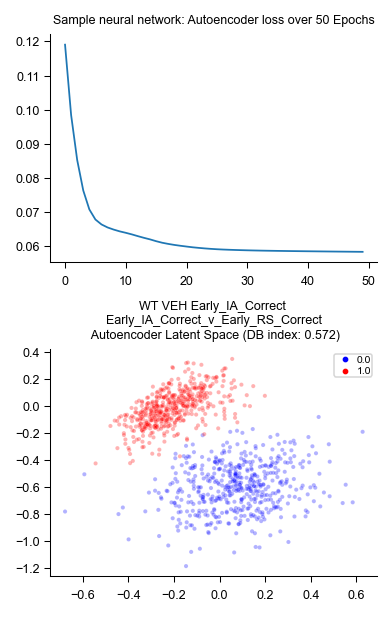

In [20]:
if plot_sample_nn:    #tailor NN for current data
    fig, ax_array = plt.subplots(2,1, figsize = (2.5,4), layout ='constrained')
    ax = ax_array[0]
    ax.plot(loss)
    ax.set_title(f'Sample neural network: Autoencoder loss over {numEpochs} Epochs')
    ### Plot latent space representation color-coded 
    ax = ax_array[1]
    with torch.no_grad():
        embed, labels =   lightning_encode(model,test_loader)##push test data throuhg encoder
    scatter = sns.scatterplot(ax = ax, x = embed[:,0], y = embed[:,1], hue =labels, palette = ['blue', 'red'], alpha = 0.3) # legend1 = ax.legend(*scatter.legend_elements()) ### according to their "true" labels
    set_labels(ax = ax, label_dict ={'title':f'{geno} {ensemble} \n{comparison}\n Autoencoder Latent Space (DB index: {round(davies_bouldin_score(embed, labels),3)})'}) #get DB index: 
    ##save fig
    fig_name = f"Sample Autoencoder ({ensemble} in {comparison})_Loss_Latent space ({numEpochs} epochs) {date_tag}"
    [fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]

## Setup Bootstrap per NN model to get DB index of latent space

In [21]:
def train_model_return_embed(dropout_net, 
                             n_cells,
                             train_loader,
                             test_loader,
                             n_epoch = 50,
                             dropout = 0,):
    ''' To create 1 models then return training points in latent space ''' 
    model =  LitAutoEncoder(dropout_net, layer_1_input=n_cells,dropout = dropout)### Instantiate your model
    history = LossHistory()
    trainer = L.Trainer(enable_model_summary=False, 
                        enable_progress_bar=False,
                        accelerator="cpu",    # ← force CPU
                        enable_checkpointing=False,
                        max_epochs=n_epoch,
                        log_every_n_steps=2,
                        callbacks = [history],)
    trainer.fit(model, train_loader);
    loss = history.train_losses #project data
    model.freeze()
    with torch.no_grad():
        embed, labels =   lightning_encode(model,test_loader)##push test data throuhg encoder
    return model, (embed, labels)
    
def train_model_get_DB_index(dropout_net, 
                             n_cells,
                            train_loader,
                            test_loader,
                            ensemble = 'Early_IA_Correct',
                            geno_day= "WT VEH",
                            comparison = 'Early_IA_Correct_v_Early_RS_Correct',
                            n_epoch = 50,
                            dropout = 0,
                            model_iter = 0):
    ''' To create B models over N epochs, then return DB index of latent space with run info appended. ''' 
    model, (embed, labels) =  train_model_return_embed(dropout_net, n_cells, train_loader, test_loader, n_epoch = 50, dropout = 0,)
    DB_index = davies_bouldin_score(embed, labels)
        #combine/store data
    run_info = dict(model_run =model_iter, 
                    DB_index = DB_index,
                    n_epochs = n_epoch,
                    final_loss = loss[-1],
                    ensemble = ensemble,
                    geno_day= geno_day,
                    comparison = comparison,
                    lossDelta = round(loss[0]-loss[-1],4))
    return run_info



In [22]:
def make_train_model_get_DB(n_cells,
                            class_matrix_store,
                            ensemble = 'Early_IA_Correct',
                            geno_day= "WT VEH",
                            comparison = 'Early_IA_Correct_v_Early_RS_Correct',
                            n_epoch = 50,
                            n_frames_to_draw = 500,
                            dropout = 0,
                            model_run:list= [0]):
    ''' Pass in raw data to resample then build dataloaders around. Resamples B datasets for B models in bootstrap'''
    #extract and reasmple data 
    class_0, class_1 = comparison.split("_v_") # print(class_0, class_1)    
    #run B bootstraps
    run_results = []
    for b in model_run: #make sure is list to iterate over 
        ensemble_resample_in_phase_dict = resample_ensemble_stage_activity(class_matrix_store,n_frames_to_draw,ensemble, geno_day, stages_to_resample= [class_0, class_1])
        long_concat_matrix,long_concat_labels =fast_pack_data_local(ensemble_resample_in_phase_dict[class_0], ensemble_resample_in_phase_dict[class_1],0,1)        #returns concat_matrix, and concat_labels
        train_dataset, test_dataset= return_train_test_tensorDataset(long_concat_matrix, long_concat_labels, shuffle = True)
        train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=500, shuffle=False,num_workers=0,persistent_workers=False)
        test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=500, shuffle=False,num_workers=0)
        n_cells = long_concat_matrix.shape[0]
        
        bootstrap_output = train_model_get_DB_index(dropout_net, 
                                                    n_cells,
                                                    train_loader,
                                                    test_loader,
                                                    ensemble = ensemble,
                                                    geno_day= geno_day,
                                                    comparison = comparison,
                                                    n_epoch = 50,
                                                    dropout = 0,
                                                    model_iter = b)
        ##get mean activity per class of bootstrap
        class_1_mean = round(ensemble_resample_in_phase_dict[class_0].values.mean(),4)
        class_2_mean = round(ensemble_resample_in_phase_dict[class_1].values.mean(),4)
        run_info = {**bootstrap_output, 'class_1_mean': class_1_mean, 'class_2_mean': class_2_mean}
        run_results.append(run_info)
    return run_results

In [23]:
dropout_level = 0.00

partial_param_nn_train = partial(make_train_model_get_DB,
                                 n_cells = n_cells,
                                 class_matrix_store=class_matrix_store,
                                 n_epoch = 50,
                                 ensemble = 'Early_IA_Correct', 
                                 geno_day= geno_order[0],
                                 comparison = 'Early_IA_Correct_v_Early_RS_Correct',
                                 dropout = dropout_level,)
partial_param_nn_train
partial_param_nn_train(model_run=[0,1])

[{'model_run': 0,
  'DB_index': 0.7908415035505463,
  'n_epochs': 50,
  'final_loss': 0.05821356922388077,
  'ensemble': 'Early_IA_Correct',
  'geno_day': 'WT VEH',
  'comparison': 'Early_IA_Correct_v_Early_RS_Correct',
  'lossDelta': 0.0608,
  'class_1_mean': 0.1259,
  'class_2_mean': 0.0373},
 {'model_run': 1,
  'DB_index': 0.6810341633805846,
  'n_epochs': 50,
  'final_loss': 0.05821356922388077,
  'ensemble': 'Early_IA_Correct',
  'geno_day': 'WT VEH',
  'comparison': 'Early_IA_Correct_v_Early_RS_Correct',
  'lossDelta': 0.0608,
  'class_1_mean': 0.1282,
  'class_2_mean': 0.038}]

In [24]:
import psutil
#16 physical cores to use 
total_cpu_physical = psutil.cpu_count(logical=False)
print(total_cpu_physical)
n_jobs= total_cpu_physical-2

16


In [25]:
run_single_bootstrap = False
start_val = 0
end_val = 100
start_end_iter = make_chunked_iterator_of_ranges(start_val,end_val, n_jobs)

if run_single_bootstrap:
    print(start_end_iter)
    output_nn = Parallel(n_jobs= n_jobs, backend="loky", verbose = 9)(delayed(partial_param_nn_train)(model_run=x) for x in start_end_iter) # 10 jobs, 500 iters, = 16 minutes with 500 samples/class fed in  (backend- Loky + CPU train )
    job_records = [pd.DataFrame.from_records(x) for x in output_nn]
    bootstrap_jobs = pd.concat(job_records)
    bootstrap_jobs

N_batches: 14
Batch_size: 7


In [26]:
if run_single_bootstrap:
    DB_of_epoch = bootstrap_jobs
    #plot N NN runs
    fig,ax = plt.subplots(1,1,figsize = (4,2.75), layout = 'constrained')
    sns.boxplot(data = DB_of_epoch, x = 'n_epochs', hue = 'geno_day', y = 'DB_index', dodge = False)#showcaps=False,fliersize = 0)
    sns.stripplot(data = DB_of_epoch, x = 'n_epochs', hue = 'geno_day', y = 'DB_index', palette = ['black'], alpha = 0.3, s = 2,dodge = False)#showcaps=False,fliersize = 0)
    
    set_labels(ax, label_dict = {'legend_false':True, 'ylim': [0.4, 1.4],
        'title': f"({date_tag}) {ensemble} ensemble in: {comparison.replace("_", " ")} \n" + 
        f" DB index Distrib over {DB_of_epoch.model_run.nunique()} NN models "+ 
                                 f"({end_val} bootstrap(s) of 500 samples/Class. weight_decay- {weight_decay}. Dropout-{dropout_level})"})
    ##save fig
    fig_name =f"{DB_of_epoch.model_run.nunique()} NN runs- {ensemble} ens- DB index {end_val} Bootstrap {dropout_level} dropout_decay {weight_decay} _{date_tag}"
    [fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]

#### Bootstrap over all combinations 

In [27]:
os.getcwd()

'G:\\My Drive\\Colab notebooks\\lightning_autoencoder'

In [28]:
last_bootstrap_run = "//data//NN 1000 bootstrap_ DB index results_24_Jun_2025.parquet"
load_last_bootstrap_output = True
#set parameters 
ens_stage_pairs_subset = {'Early_IA_Correct_v_Early_RS_Correct':['Early_IA_Correct', 'Early_RS_Correct'],
                              'Early_IA_Error_v_Early_RS_Error':['Early_IA_Error', 'Early_RS_Error'],
                              'Late_IA_v_Early_RS_Correct':['Late_IA', 'Early_RS_Correct'],
                              'Early_IA_Correct_v_Late_IA':['Early_IA_Correct','Late_IA'] }
geno_plot = geno_order_w_WT_CLNZ
    
if load_last_bootstrap_output:
    bootstrap_output =pd.read_parquet(os.getcwd()+ last_bootstrap_run)
else:
    #16 physical cores to use 
    n_jobs= 14
    start_val = 0
    end_val = 100
    #input data- stage_resample_by_geno_ensemble = ensemble > geno > stage activity
    start_end_iter = make_chunked_iterator_of_ranges(start_val,end_val, n_jobs)
    print(start_end_iter)
    ## set params for loop
    dropout_level = 0.00
    bootstrap_NN = True
    ##  MAIN AUTOENC LOOP
    bootstrap_storage = []
    if bootstrap_NN:
        # 6458.94s/it | 100 min/iter for 14 jobs 300 NN bootstraps
        for comparison, ensemble_list in tqdm(ens_stage_pairs_subset.items()):            # print(f" Decoding stages {comparison} for ensembles {ensemble_list}")
            class_0, class_1 = comparison.split("_v_") # print(class_0, class_1)
            for ensemble in ensemble_list: #iterate over all ensembles(comparisons are locked to 1 per ensemble list
                for g_count, geno in enumerate(geno_plot): #iterate over geno days    
                    print(f" {comparison} - {ensemble} {geno} autoencoder run")
                    ### freeze function, creates bootstrap per run
                    partial_param_nn_train = partial(make_train_model_get_DB,
                                                     n_cells = n_cells,
                                                     class_matrix_store=class_matrix_store,
                                                     n_epoch = 50,
                                                     ensemble = ensemble, 
                                                     geno_day= geno,
                                                     comparison = comparison,
                                                     dropout = dropout_level,)
                    # ## run job in paralell 
                    output_nn = Parallel(n_jobs= n_jobs, backend="loky", verbose = 9)(delayed(partial_param_nn_train)(model_run=x) for x in start_end_iter) # 10 jobs, 500 iters, = 16 minutes with 500 samples/class fed in  (backend- Loky + CPU train )
                    #save.concat paralell output
                    job_records = [pd.DataFrame.from_records(x) for x in output_nn]
                    bootstrap_jobs = pd.concat(job_records)
                    bootstrap_storage.append(bootstrap_jobs) #list of DFs with info on B NNs created/projected
    bootstrap_output = pd.concat(bootstrap_storage)
    #save database of B shuff
    nn_bootstrap_filename  = current_run_output + f"NN {end_val} bootstrap_ DB index results_{date_tag}.parquet"
    print(f"saved bootstrap output file: {nn_bootstrap_filename}")
    bootstrap_output.to_parquet(nn_bootstrap_filename)

#regardless of choice for acquiring df, print info
print(bootstrap_output.info())
bootstrap_output.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 9
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model_run     40000 non-null  int64  
 1   DB_index      40000 non-null  float64
 2   n_epochs      40000 non-null  int64  
 3   final_loss    40000 non-null  float64
 4   ensemble      40000 non-null  object 
 5   geno_day      40000 non-null  object 
 6   comparison    40000 non-null  object 
 7   lossDelta     40000 non-null  float64
 8   class_1_mean  40000 non-null  float64
 9   class_2_mean  40000 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 3.4+ MB
None


,model_run,DB_index,n_epochs,final_loss,ensemble,geno_day,comparison,lossDelta,class_1_mean,class_2_mean
0,0,0.569982,50,0.058213,Early_IA_Correct,WT VEH,Early_IA_Correct_v_Early_RS_Correct,0.0534,0.1263,0.0378
1,1,0.530064,50,0.058002,Early_IA_Correct,WT VEH,Early_IA_Correct_v_Early_RS_Correct,0.0679,0.1262,0.0377
2,2,0.536322,50,0.058013,Early_IA_Correct,WT VEH,Early_IA_Correct_v_Early_RS_Correct,0.0626,0.1263,0.0380
3,3,0.690213,50,0.057403,Early_IA_Correct,WT VEH,Early_IA_Correct_v_Early_RS_Correct,0.0722,0.1250,0.0380
4,4,0.717310,50,0.057517,Early_IA_Correct,WT VEH,Early_IA_Correct_v_Early_RS_Correct,0.0739,0.1232,0.0389


[None, None]

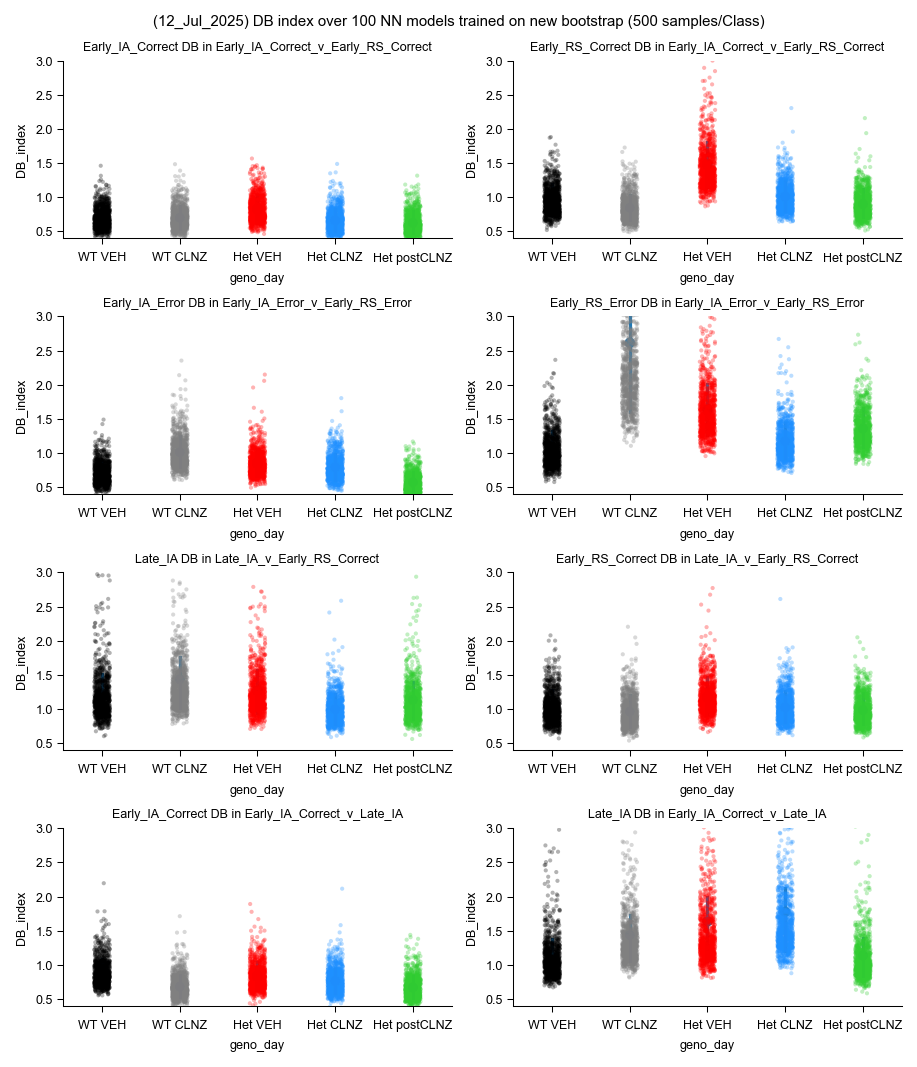

In [29]:

#plot N NN runs
fig,ax_array = plt.subplots(len(ens_stage_pairs_subset.keys()),2, figsize = (6,7), layout = 'constrained')
for c, comparison in enumerate(ens_stage_pairs_subset.keys()):
    for e, ens in enumerate(ens_stage_pairs_subset[comparison]):
        ax = ax_array[c,e]
        facet_mask = (bootstrap_output.comparison == comparison) & (bootstrap_output.ensemble ==ens)
        plot_db = bootstrap_output.loc[facet_mask, :]
        sns.pointplot(ax = ax, data = plot_db, x = 'geno_day',  y = 'DB_index', order = geno_order_w_WT_CLNZ, linestyles = 'None', dodge = False,errorbar = ('pi', 75))#showcaps=False,fliersize = 0)
        sns.stripplot(ax = ax, data =plot_db, x = 'geno_day', y = 'DB_index', **geno_order_w_WT_CLNZ_no_eb, alpha = 0.3, s = 2,dodge = False)#showcaps=False,fliersize = 0)
        set_labels(ax, label_dict = {'legend_false':True, 'ylim': [0.4, 3], 'title': f"{ens} DB in {comparison}"})
    
##save fig
fig.suptitle(f"({date_tag}) DB index over {end_val} NN models trained on new bootstrap (500 samples/Class)")
fig_name =f"{end_val} NN boostrap-  DB index with {dropout_level} dropout_decay {weight_decay} _{date_tag}"
# save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'png'])
[fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]

#### Create Latent Space Viz- 1 autoencoder per comparison x ensembles

In [30]:
def save_metadata_record(last_run_metadata_record:pd.DataFrame, metadata_record_filename:str, save_loc:str):
    #write filename to dF
    
    if not os.path.exists(metadata_record_filename):    #create locally then save
        print(f"creating autoencoder versioning file: {metadata_record_filename}")
        last_run_metadata_record.to_csv(metadata_record_filename,index = False)
    else: #load existing and add to it 
        print(f"Loading autoencoder versioning file: {metadata_record_filename}")
        metadata_record= pd.read_csv(metadata_record_filename)
        metadata_record = pd.concat([metadata_record, last_run_metadata_record]) #join prev df with latest DF
        #save multiple backups 
        # metadata_record.to_csv(metadata_record_filename) 
        metadata_record.to_csv(save_loc + metadata_record_filename)
        metadata_record.to_csv(csv_folder_most_recent +metadata_record_filename)
        metadata_record.to_csv(csv_folder_current_run + metadata_record_filename)


In [31]:
print(os.getcwd())
#preset the storage output name:
torch_model_storage = f"torch_model_storage_{date_tag}\\"
print(f'saving to {torch_model_storage}')
make_folder(torch_model_storage)

G:\My Drive\Colab notebooks\lightning_autoencoder
saving to torch_model_storage_12_Jul_2025\
The folder 'torch_model_storage_12_Jul_2025\' has been created.


In [32]:
run_autoencoder=False
save_model = True

In [33]:
#set the dataset filters to use when making things 
ensemble_plot = ['Early_IA_Correct', 'Early_RS_Correct', 'Early_IA_Error', 'Early_RS_Error'] #what ensembles do you care about
geno_plot =  geno_order_w_WT_CLNZ
decode_plot = ['Early_IA_Correct_v_Early_IA_Error', 'Early_IA_Correct_v_Early_RS_Correct', 'Early_IA_Error_v_Early_RS_Error', 'Early_RS_Correct_v_Early_RS_Error'] #what class comparisons do you care about
run_info_list = [] #store the gathered data
## set params for current run 
run_params = dict(dropout = 0.05, numEpochs = 50,n_frames_to_draw= 500, BATCH_SIZE = 250, NUM_WORKERS = 2, test_on_train= False,lr=0.0125)#gather into run params
if run_params['test_on_train']:
    run_params['n_frames_to_draw']= run_params['n_frames_to_draw']*2
## MAIN AUTOENC LOOP
ens_stage_pairs_subset = {'Early_IA_Correct_v_Early_RS_Correct':['Early_IA_Correct', 'Early_RS_Correct'],
                          'Early_IA_Error_v_Early_RS_Error':['Early_IA_Error', 'Early_RS_Error'],
                          'Late_IA_v_Early_RS_Correct':['Late_IA', 'Early_RS_Correct'],
                          'Early_IA_Correct_v_Late_IA':['Early_IA_Correct','Late_IA'] }
if run_autoencoder:
    make_folder(torch_model_storage)
    for comparison, ensemble_list in tqdm(ens_stage_pairs_subset.items()):            # print(f" Decoding stages {comparison} for ensembles {ensemble_list}")
        class_0, class_1 = comparison.split("_v_") # print(class_0, class_1)
        for ensemble in ensemble_list: #iterate over all ensembles(comparisons are locked to 1 per ensemble list
            for g_count, geno in enumerate(geno_plot): #iterate over geno days             
                ensemble_resample_in_phase_dict = resample_ensemble_stage_activity(class_matrix_store,n_frames_to_draw,ensemble, geno, stages_to_resample= stage_names)
                long_concat_matrix,long_concat_labels =fast_pack_data_local(ensemble_resample_in_phase_dict[class_0], ensemble_resample_in_phase_dict[class_1],0,1)        #returns concat_matrix, and concat_labels
                train_dataset, test_dataset= return_train_test_tensorDataset(long_concat_matrix, long_concat_labels, shuffle = True,test_on_train = run_params['test_on_train'])
                n_cells = long_concat_matrix.shape[0]
                train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=run_params['BATCH_SIZE'],pin_memory= True, shuffle=True,num_workers=run_params['NUM_WORKERS'],persistent_workers=True)
                test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=run_params['BATCH_SIZE'],pin_memory= True, shuffle=True,num_workers=run_params['NUM_WORKERS'])
                ### Instantiate your model
                model, (embed,labels) =  train_model_return_embed(dropout_net, n_cells,train_loader,test_loader,n_epoch = 50,dropout = 0,)
                # #save info
                run_info = dict(classes_decoded = comparison, 
                                geno_day= geno,
                                ensemble = ensemble,
                                class_0 = class_0,
                                class_1 = class_1, 
                                n_frames = long_concat_matrix.shape[0],
                                num_epochs = run_params['numEpochs'], 
                                mean_loss = np.mean(loss[-10:]),
                                n_cells = n_cells, 
                                dropout = run_params['dropout'], 
                                test_on_train=run_params['test_on_train'],
                               date_run = date_tag)
                ##freeze and save model for more embeddings later
                if save_model:
                    torch.save(model.state_dict(), torch_model_storage+ f'model_{"_".join([comparison,geno,ensemble])}.pt')
                    # trainer.save_checkpoint(torch_model_storage+ f'model_checkpoint_{"_".join([comparison,geno,ensemble,".ckpt"])}')
                #Test data- create embeddings 
                embed_df = pd.DataFrame(np.hstack([embed, labels[:,np.newaxis]]), columns = ['embed_1', 'embed_2', 'labels']).assign(**run_info)       
                ##convert categories for space efficiency
                conversion_cols = dict(classes_decoded = 'category', geno_day= 'category', ensemble = 'category',class_0 = 'category', class_1 = 'category', n_frames = 'Int64',date_run = 'category',labels= 'category')
                embed_df.loc[:, list(conversion_cols.keys())] = embed_df.loc[:, list(conversion_cols.keys())].astype(conversion_cols)
                run_info_list.append(embed_df)
    #save run params 
    embed_record = pd.concat(run_info_list)
    embed_record["labels"]= np.where(embed_record["labels"] == 0.0, embed_record["class_0"], embed_record["class_1"])
    
    filename = torch_model_storage+ f"run_param_{date_tag}.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(run_params, file)

In [34]:
autoencoder_record = 'last_autoencoder_run_info.txt'
load_current = False
if load_current:
    autoencoder_run_versions = f"autoencoder project- run version record_{date_tag}.csv"
else:
    autoencoder_run_versions = f"autoencoder project- run version record_28_Jun_2025.csv"
resample_type_str = {True: f"_Embed Train Data", False: f"_Embed New Data"}
#save files based on conditions
if run_autoencoder:
    #save embed record
    file_name = f"Autoencoder_latent_space_{date_tag}_{run_params['n_frames_to_draw']}Sample.parquet"
    embed_record.to_parquet(file_name, compression='snappy')
    ## save loc of current encoder
    f = open(autoencoder_record, "w")
    autoencode_run_info_str = f"latest autoencoder output filename: {file_name}. Run end: {date_tag}. Data used: {trial_df_filename}"
    f.write(autoencode_run_info_str)
    f.close()
    print(autoencode_run_info_str)
    ## DATA VERSIONING #create run information df
    run_info = {'run_date': date_tag, 
                'run_dataset_used': trial_df_filename,
                'n_epoch': run_params['numEpochs'],
                'n_class_frames':run_params['n_frames_to_draw'],
                'ensembles_ran': [ensemble_plot],
                'classes_ran': [decode_plot],
                'file_name':file_name,
                'test_on_train': run_params['test_on_train'],
                'model_locations': torch_model_storage,
               'lr':0.0125}
    run_record = pd.DataFrame.from_dict(run_info)
    #write filename to dF
    file_loc = data_folder
    #manually save csv
    run_record.to_csv(data_folder + autoencoder_run_versions)
    # save_metadata_record(last_run_metadata_record=run_record, 
    #                      metadata_record_filename=autoencoder_run_versions,
    #                      save_loc=folder_name)    
else: #if you already have an autoencoder result to open
    run_record= pd.read_csv(data_folder+ autoencoder_run_versions)
    f = open(autoencoder_record, "r")
    autoencode_run_txt = f.read()
    autoencode_filename = autoencode_run_txt.split(': ')[1].split('. Run')[0]
    print(autoencode_filename)
    embed_record =pd.read_parquet(autoencode_filename)
print(run_record.iloc[-5:,:])
embed_record

Autoencoder_latent_space_28_Jun_2025_500Sample.parquet
   Unnamed: 0     run_date                                   run_dataset_used  \
0           0  28_Jun_2025  G:\My Drive\Colab notebooks\lightning_autoenco...   

   n_epoch  n_class_frames                                      ensembles_ran  \
0       50             500  ['Early_IA_Correct', 'Early_RS_Correct', 'Earl...   

                                         classes_ran  \
0  ['Early_IA_Correct_v_Early_IA_Error', 'Early_I...   

                                           file_name  test_on_train  \
0  Autoencoder_latent_space_28_Jun_2025_500Sample...          False   

                    model_locations      lr  
0  torch_model_storage_28_Jun_2025\  0.0125  


,embed_1,embed_2,labels,classes_decoded,geno_day,ensemble,class_0,class_1,n_frames,num_epochs,mean_loss,n_cells,dropout,test_on_train,date_run
0,0.391793,-0.461520,Early_IA_Correct,Early_IA_Correct_v_Early_RS_Correct,WT VEH,Early_IA_Correct,Early_IA_Correct,Early_RS_Correct,109,50,0.058566,109,0.05,False,28_Jun_2025
1,0.109306,-0.329513,Early_RS_Correct,Early_IA_Correct_v_Early_RS_Correct,WT VEH,Early_IA_Correct,Early_IA_Correct,Early_RS_Correct,109,50,0.058566,109,0.05,False,28_Jun_2025
2,-0.110651,-0.067849,Early_RS_Correct,Early_IA_Correct_v_Early_RS_Correct,WT VEH,Early_IA_Correct,Early_IA_Correct,Early_RS_Correct,109,50,0.058566,109,0.05,False,28_Jun_2025
3,0.743984,-0.585750,Early_IA_Correct,Early_IA_Correct_v_Early_RS_Correct,WT VEH,Early_IA_Correct,Early_IA_Correct,Early_RS_Correct,109,50,0.058566,109,0.05,False,28_Jun_2025
4,1.190619,-0.347470,Early_IA_Correct,Early_IA_Correct_v_Early_RS_Correct,WT VEH,Early_IA_Correct,Early_IA_Correct,Early_RS_Correct,109,50,0.058566,109,0.05,False,28_Jun_2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.122755,0.148106,Late_IA,Early_IA_Correct_v_Late_IA,Het postCLNZ,Late_IA,Early_IA_Correct,Late_IA,105,50,0.058566,105,0.05,False,28_Jun_2025
496,0.244647,1.240102,Early_IA_Correct,Early_IA_Correct_v_Late_IA,Het postCLNZ,Late_IA,Early_IA_Correct,Late_IA,105,50,0.058566,105,0.05,False,28_Jun_2025
497,-0.061518,0.075288,Late_IA,Early_IA_Correct_v_Late_IA,Het postCLNZ,Late_IA,Early_IA_Correct,Late_IA,105,50,0.058566,105,0.05,False,28_Jun_2025
498,0.482187,1.156507,Early_IA_Correct,Early_IA_Correct_v_Late_IA,Het postCLNZ,Late_IA,Early_IA_Correct,Late_IA,105,50,0.058566,105,0.05,False,28_Jun_2025


In [35]:
test_write = False
if test_write:
    print("CWD =", os.getcwd())
    with open("test_write.txt", "w") as f:
        f.write("hello\n")
    print("Wrote test_write.txt successfully.")

In [36]:
os.getcwd()

'G:\\My Drive\\Colab notebooks\\lightning_autoencoder'

## Bootstrap density score- embedded

In [37]:
run_latent_embedding_sample= False

ensemble_plot = ['Early_IA_Correct', 'Early_RS_Correct', 'Early_IA_Error', 'Early_RS_Error']
geno_plot =  geno_order
decode_plot = ['Early_IA_Correct_v_Early_IA_Error', 'Early_IA_Correct_v_Early_RS_Correct', 'Early_IA_Error_v_Early_RS_Error', 'Early_RS_Correct_v_Early_RS_Error']
run_info_list = []

#### Run bootstrap projections and/or load previous bootstrap projections

In [38]:
def set_bootstrap_index_every_N_rows(input_df:pd.DataFrame = pd.DataFrame(),
                                     input_filter= ['classes_decoded','ensemble','geno_day'],
                                     n_class_samples:int = 400, 
                                     bootstrap_col_name:str = 'strap'):
    ''' To get every N rows (default N = 400) and assign to a bootstrap index'''
    grouped_df = []
    for group_key, group_df in input_df.groupby(by = input_filter):
        grouped_df.append(group_df.assign(
            **{bootstrap_col_name: group_df.reset_index().index.values//n_class_samples}))
    grouped_df = pd.concat(grouped_df)
    return grouped_df

def balance_labels_of_bootstrap(df:pd.DataFrame, labels:list = [0,1], **kwargs):
    '''' to get label 1 df and label 2 df, recombine then export'''
    ##get labels == 0 df, then labels == 1
    df_1 = df[df['labels'] == labels[0]]
    df_2 = df[df['labels'] == labels[1]]
    # add bootstrap index
    group_df_1 = set_bootstrap_index_every_N_rows(df_1, **kwargs)
    group_df_2 =set_bootstrap_index_every_N_rows(df_2, **kwargs)
    #recombine into bootstrap projections df
    balanced_df = pd.concat([group_df_1,group_df_2], ignore_index=True)
    return balanced_df

#### Check spread by bootstrap iteration

In [39]:
mean_density = bootstrap_output.set_index(['comparison', 'ensemble'])
mean_density

model_run  DB_index  \
comparison                          ensemble                                
Early_IA_Correct_v_Early_RS_Correct Early_IA_Correct          0  0.569982   
                                    Early_IA_Correct          1  0.530064   
                                    Early_IA_Correct          2  0.536322   
                                    Early_IA_Correct          3  0.690213   
                                    Early_IA_Correct          4  0.717310   
...                                                         ...       ...   
Early_IA_Correct_v_Late_IA          Late_IA                 995  0.662648   
                                    Late_IA                 996  1.285270   
                                    Late_IA                 997  1.219843   
                                    Late_IA                 998  1.165503   
                                    Late_IA                 999  1.054447   

                                                      n_epochs  final_loss  \
comparison                          ensemble                                 
Early_IA_Correct_v_Early_RS_Correct Early_IA_Correct        50    0.058213   
                                    Early_IA_Correct        50    0.058002   
                                    Early_IA_Correct        50    0.058013   
                                    Early_IA_Correct        50    0.057403   
                                    Early_IA_Correct        50    0.057517   
...                                                        ...         ...   
Early_IA_Correct_v_Late_IA          Late_IA                 50    0.074943   
                                    Late_IA                 50    0.074573   
                                    Late_IA                 50    0.074646   
                                    Late_IA                 50    0.075047   
                                    Late_IA                 50    0.074917   

                                                          geno_day  lossDelta  \
comparison                          ensemble                                    
Early_IA_Correct_v_Early_RS_Correct Early_IA_Correct        WT VEH     0.0534   
                                    Early_IA_Correct        WT VEH     0.0679   
                                    Early_IA_Correct        WT VEH     0.0626   
                                    Early_IA_Correct        WT VEH     0.0722   
                                    Early_IA_Correct        WT VEH     0.0739   
...                                                            ...        ...   
Early_IA_Correct_v_Late_IA          Late_IA           Het postCLNZ     0.0731   
                                    Late_IA           Het postCLNZ     0.0719   
                                    Late_IA           Het postCLNZ     0.0690   
                                    Late_IA           Het postCLNZ     0.0872   
                                    Late_IA           Het postCLNZ     0.0595   

                                                      class_1_mean  \
comparison                          ensemble                         
Early_IA_Correct_v_Early_RS_Correct Early_IA_Correct        0.1263   
                                    Early_IA_Correct        0.1262   
                                    Early_IA_Correct        0.1263   
                                    Early_IA_Correct        0.1250   
                                    Early_IA_Correct        0.1232   
...                                                            ...   
Early_IA_Correct_v_Late_IA          Late_IA                 0.0862   
                                    Late_IA                 0.0871   
                                    Late_IA                 0.0876   
                                    Late_IA                 0.0864   
                                    Late_IA                 0.0859   

                                                      class_2_mean  
com

#### Plot density score per bootstrap

In [69]:
unique_comparisons = list(set(mean_density.index.get_level_values('comparison')))
unique_comparisons

['Early_IA_Correct_v_Late_IA',
 'Early_IA_Correct_v_Early_RS_Correct',
 'Early_IA_Error_v_Early_RS_Error',
 'Late_IA_v_Early_RS_Correct']

In [70]:
score_df = mean_density
score_type = 'Davies-Bouldin index'
comparison =unique_comparisons[0]
comparison_df =score_df.loc[comparison,:]
ensemble_subset = list(set(comparison_df.index.get_level_values('ensemble')))
print(ensemble_subset)
comparison_df


['Early_IA_Correct', 'Late_IA']


,model_run,DB_index,n_epochs,final_loss,geno_day,lossDelta,class_1_mean,class_2_mean
ensemble,,,,,,,,
Early_IA_Correct,0,0.680892,50,0.062299,WT VEH,0.0642,0.1253,0.0465
Early_IA_Correct,1,0.929763,50,0.062354,WT VEH,0.0663,0.1256,0.0462
Early_IA_Correct,2,0.927431,50,0.062624,WT VEH,0.0659,0.1257,0.0470
Early_IA_Correct,3,0.872266,50,0.063303,WT VEH,0.0654,0.1270,0.0478
Early_IA_Correct,4,0.819451,50,0.063191,WT VEH,0.0571,0.1279,0.0474
...,...,...,...,...,...,...,...,...
Late_IA,995,0.662648,50,0.074943,Het postCLNZ,0.0731,0.0862,0.1370
Late_IA,996,1.285270,50,0.074573,Het postCLNZ,0.0719,0.0871,0.1333
Late_IA,997,1.219843,50,0.074646,Het postCLNZ,0.0690,0.0876,0.1335


With axis variable == Hue variable:
With axis variable == Hue variable:
With axis variable == Hue variable:
With axis variable == Hue variable:
With axis variable == Hue variable:
With axis variable == Hue variable:
With axis variable == Hue variable:
With axis variable == Hue variable:


[None, None]

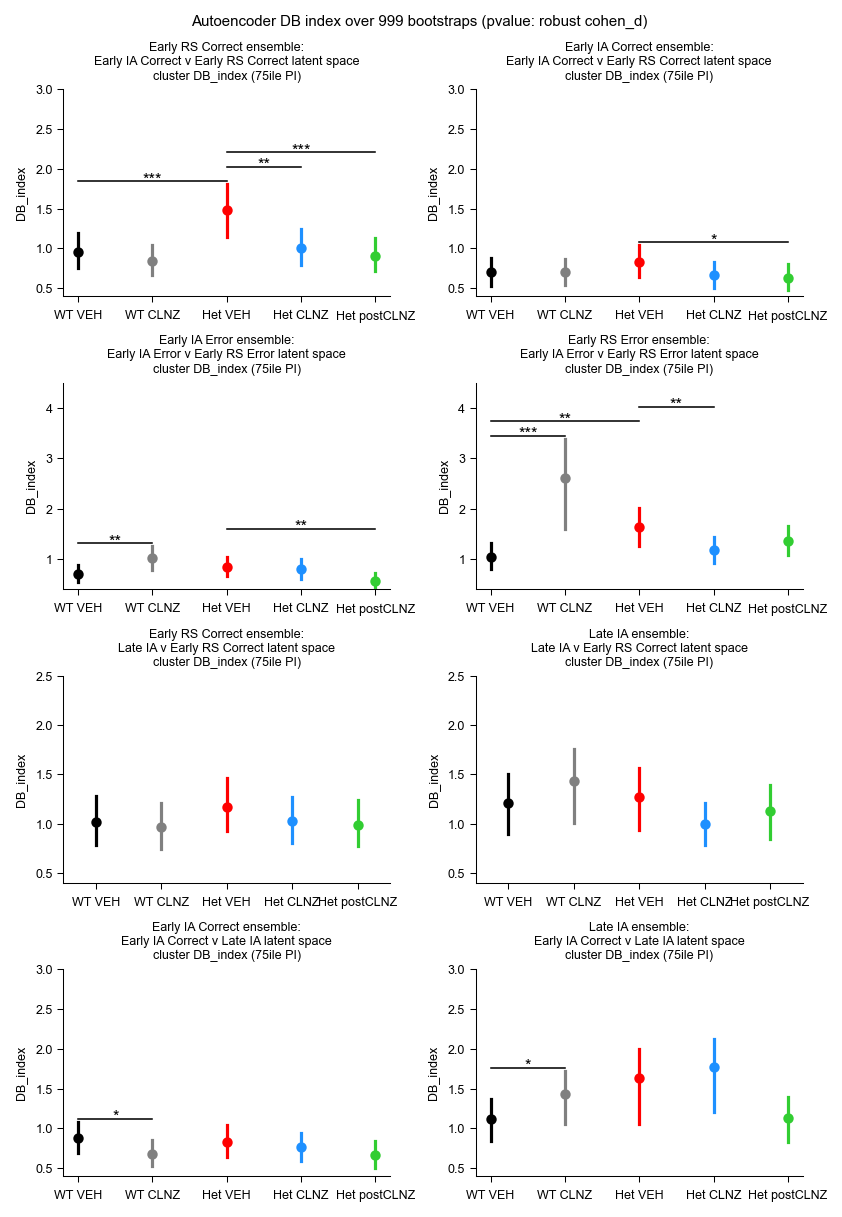

In [71]:

fig_dims = dict(ncols=2,nrows = mean_density.reset_index().comparison.nunique())
fig,ax_array = plt.subplots(**fig_dims, figsize = (2.75*fig_dims['ncols'], 2*fig_dims['nrows']), sharey= False,
                             layout = 'constrained')
score_df = mean_density
score_type = 'DB_index'

# score_type = 'Davies-Bouldin index'
posthoc_list = []
ylim_list = [[0.4,3],
             [0.4,4.5],
             [0.4,2.5],
            [0.4,3]]
stat_test = 'cohen_d'
#iterate over comparisons
for c, comparison in enumerate(mean_density.reset_index().comparison.unique()):
    comparison_df =score_df.loc[comparison,:]
    ensemble_subset = list(set(comparison_df.index.get_level_values('ensemble')))
    for e,ensemble in enumerate(ensemble_subset): #iterate over ensembles
        plot_score =comparison_df.loc[ensemble,:]
        
        plot_ax = ax_array[c,e]
        plot_params = dict(data = plot_score, x = 'geno_day', y =score_type,
                           order = geno_order_w_WT_CLNZ, **format_no_eb_w_WT_CLNZ,)# palette = color_list, order = geno_order, hue_order = geno_order,  hue = 'geno_day')
        sc = sns.pointplot(ax =plot_ax, errorbar = ('pi',75),dodge = False, **plot_params)
        # plot_ax.get_legend().remove()    
        ax_title = f"{ensemble.replace("_", " ")} ensemble:\n{comparison.replace("_", " ")} latent space\ncluster {score_type} (75ile PI)"
        set_labels(ax =plot_ax, label_dict = {'title': ax_title, 'legend_false': True , 'xlabel': None,'ylim': ylim_list[c]})
        
        ## plot stat annotate
        posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(plot_ax, plot_params, sc,
                                                               comparison_list_w_WT_CLNZ, 
                                                               test_name = stat_test,
                                                               ax_var_is_hue=True,detect_error_bar = True)
        plot_sig_bars_w_comp_df_tight(plot_ax, posthoc_df[posthoc_df['pvalue'] < 0.05], tight_offset = 0.015,offset_constant=0.015) 
        comparison_name=f"{ensemble.replace("_", " ")} ensemble:\n{comparison.replace("_", " ")} latent space"
        
        posthoc_list.append(posthoc_df.assign(comparison=   comparison_name))
        
posthoc_df = pd.concat(posthoc_list)
##save fig & CSV
n_shuffles = score_df.model_run.max()
fig_name = f"Autoencoder-DB index {n_shuffles} bootstrap (pvalue- {stat_test}) "
fig.suptitle(f"Autoencoder DB index over {n_shuffles} bootstraps (pvalue: robust {stat_test}) ")
#save posthoc CSV
# save_plot_record_as_csv_txt(posthoc_df,folder_pref:="4",fig_name,csv_folder_most_recent, csv_folder_current_run,
#                                 csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")
# save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
[fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]

[None, None]

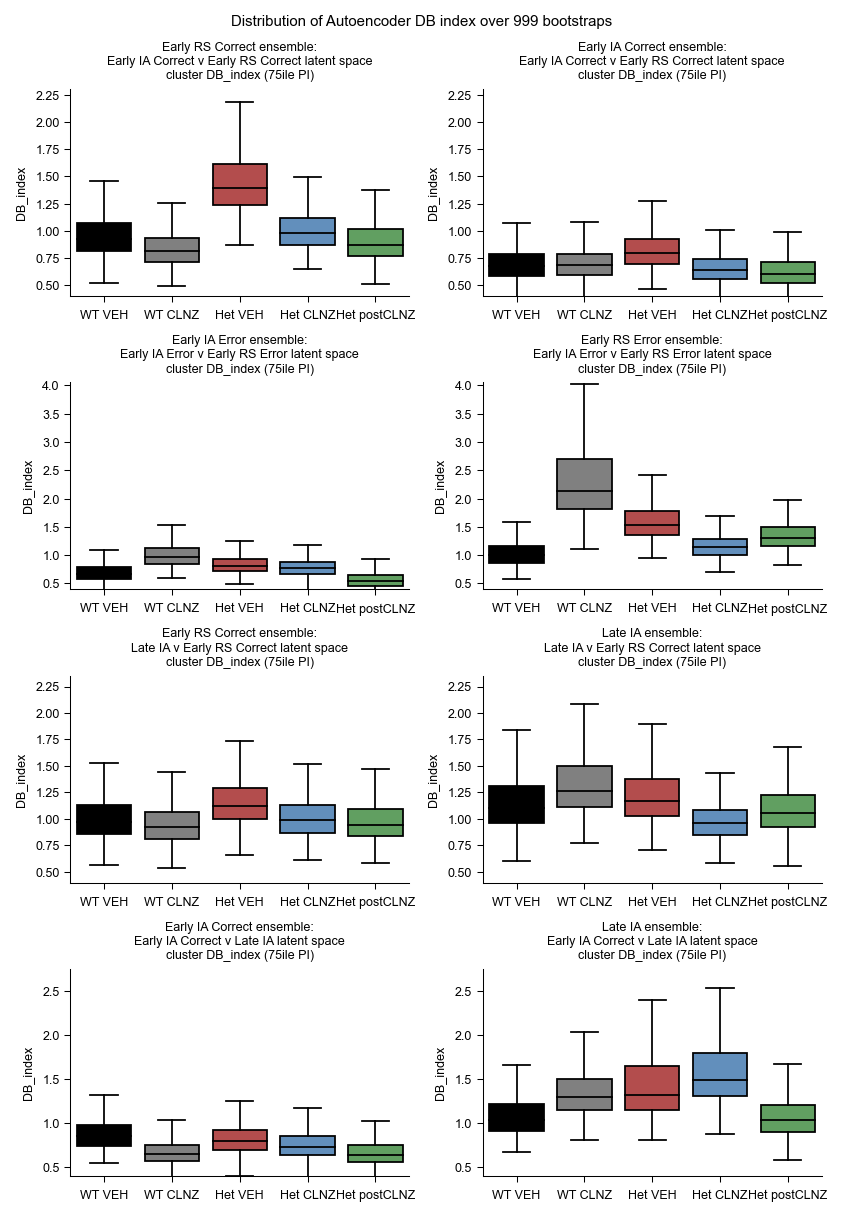

In [72]:

fig_dims = dict(ncols=2,nrows = mean_density.reset_index().comparison.nunique())
fig,ax_array = plt.subplots(**fig_dims, figsize = (2.75*fig_dims['ncols'], 2*fig_dims['nrows']), sharey= False,
                             layout = 'constrained')
score_df = mean_density
score_type = 'DB_index'

# score_type = 'Davies-Bouldin index'
posthoc_list = []
ylim_list = [[0.4,2.3],
             [0.4,4.05],
             [0.4,2.35],
            [0.4,2.75]]
#iterate over comparisons
for c, comparison in enumerate(mean_density.reset_index().comparison.unique()):
    comparison_df =score_df.loc[comparison,:]
    ensemble_subset = list(set(comparison_df.index.get_level_values('ensemble')))
    for e,ensemble in enumerate(ensemble_subset): #iterate over ensembles
        plot_score =comparison_df.loc[ensemble,:]
        
        plot_ax = ax_array[c,e]
        plot_params = dict(data = plot_score, x = 'geno_day', y =score_type,
                           order = geno_order_w_WT_CLNZ, **format_no_eb_w_WT_CLNZ,)# palette = color_list, order = geno_order, hue_order = geno_order,  hue = 'geno_day')
        sc = sns.boxplot(ax =plot_ax, fliersize =0,dodge = False,saturation = 0.4, **plot_params)
        # plot_ax.get_legend().remove()    
        ax_title = f"{ensemble.replace("_", " ")} ensemble:\n{comparison.replace("_", " ")} latent space\ncluster {score_type} (75ile PI)"
        
        # ## plot stat annotate
        # posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(plot_ax, plot_params, sc,
        #                                                        comparison_list_w_WT_CLNZ, 
        #                                                        test_name = 'permutation_test',ax_var_is_hue=True,detect_error_bar = True)
        # plot_sig_bars_w_comp_df_tight(plot_ax, posthoc_df[posthoc_df['pvalue'] < 0.05], tight_offset = 0.02,offset_constant=0.015) 
        comparison_name=f"{ensemble.replace("_", " ")} ensemble:\n{comparison.replace("_", " ")} latent space"
        set_labels(ax =plot_ax, label_dict = {'title': ax_title, 'legend_false': True , 'xlabel': None,'ylim': ylim_list[c]})
        # posthoc_list.append(posthoc_df.assign(comparison=   comparison_name))

fig_name = f"Distribution of Autoencoder DB index over {n_shuffles} bootstraps"
fig.suptitle(fig_name)

#save posthoc CSV
# save_plot_record_as_csv_txt(posthoc_df,folder_pref:="4",fig_name,csv_folder_most_recent, csv_folder_current_run,
#                                 csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")
# save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
[fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]

In [73]:
cols_to_drop = ['y_is_nonnan', 'y_is_2_elem',
                'g_1_child_x','g_1_child_y',
                'g_2_child_x','g_2_child_y',
                'g1_num_loc','g2_num_loc',
                'g1_cat_loc','g2_cat_loc',
                'hue_group_1_locs','hue_group_2_locs',
                'group_1_order_pos', 'group_2_order_pos',
                'group_1_order_pos', 'group_2_order_pos']
all_posthoc = posthoc_df.drop(cols_to_drop, axis = 1)
all_posthoc.to_csv(f"DB index mean diff {stat_test} posthoc test.csv")
all_posthoc

,category_compared_within,group_1,group_2,group_1_n,group_2_n,group_1_mean,group_1_sem,group_2_mean,group_2_sem,test_name,stat_result,pvalue,categorical_subgroup,max_group_loc_val,numeric_var,hue_var,x_category_var,hue_is_x_axis,comparison
0,geno_day,WT VEH,WT CLNZ,"(1000,)","(1000,)",0.9405,0.1243,0.8270,0.1046,robust_cohen_d,"[0.98838, 0.16148, 0.0001]",0.161484,"(WT VEH, WT CLNZ)",1.193701,DB_index,geno_day,geno_day,True,Early RS Correct ensemble:\nEarly IA Correct v...
1,geno_day,WT VEH,Het VEH,"(1000,)","(1000,)",0.9405,0.1243,1.4186,0.1783,robust_cohen_d,"[3.1112, 0.00093, 0.0001]",0.000932,"(WT VEH, Het VEH)",1.809894,DB_index,geno_day,geno_day,True,Early RS Correct ensemble:\nEarly IA Correct v...
2,geno_day,Het VEH,Het CLNZ,"(1000,)","(1000,)",1.4186,0.1783,0.9919,0.1199,robust_cohen_d,"[2.80865, 0.00249, 0.0001]",0.002487,"(Het VEH, Het CLNZ)",1.809894,DB_index,geno_day,geno_day,True,Early RS Correct ensemble:\nEarly IA Correct v...
3,geno_day,Het VEH,Het postCLNZ,"(1000,)","(1000,)",1.4186,0.1783,0.8868,0.1172,robust_cohen_d,"[3.52522, 0.00021, 0.0001]",0.000212,"(Het VEH, Het postCLNZ)",1.809894,DB_index,geno_day,geno_day,True,Early RS Correct ensemble:\nEarly IA Correct v...
0,geno_day,WT VEH,WT CLNZ,"(1000,)","(1000,)",0.6860,0.0942,0.6860,0.0927,robust_cohen_d,"[0.00045, 0.49982, 0.9933]",0.499820,"(WT VEH, WT CLNZ)",0.876804,DB_index,geno_day,geno_day,True,Early IA Correct ensemble:\nEarly IA Correct v...
1,geno_day,WT VEH,Het VEH,"(1000,)","(1000,)",0.6860,0.0942,0.8105,0.1115,robust_cohen_d,"[1.206, 0.11391, 0.0001]",0.113908,"(WT VEH, Het VEH)",1.038142,DB_index,geno_day,geno_day,True,Early IA Correct ensemble:\nEarly IA Correct v...
2,geno_day,Het VEH,Het CLNZ,"(1000,)","(1000,)",0.8105,0.1115,0.6471,0.0871,robust_cohen_d,"[1.63243, 0.05129, 0.0001]",0.051295,"(Het VEH, Het CLNZ)",1.038142,DB_index,geno_day,geno_day,True,Early IA Correct ensemble:\nEarly IA Correct v...
3,geno_day,Het VEH,Het postCLNZ,"(1000,)","(1000,)",0.8105,0.1115,0.6140,0.0895,robust_cohen_d,"[1.94322, 0.02599, 0.0001]",0.025995,"(Het VEH, Het postCLNZ)",1.038142,DB_index,geno_day,geno_day,True,Early IA Correct ensemble:\nEarly IA Correct v...
0,geno_day,WT VEH,WT CLNZ,"(1000,)","(1000,)",0.6852,0.0956,0.9857,0.1276,robust_cohen_d,"[2.66517, 0.00385, 0.0001]",0.003847,"(WT VEH, WT CLNZ)",1.253592,DB_index,geno_day,geno_day,True,Early IA Error ensemble:\nEarly IA Error v Ear...
1,geno_day,WT VEH,Het VEH,"(1000,)","(1000,)",0.6852,0.0956,0.8298,0.1063,robust_cohen_d,"[1.42986, 0.07638, 0.0001]",0.076378,"(WT VEH, Het VEH)",1.037653,DB_index,geno_day,geno_day,True,Early IA Error ensemble:\nEarly IA Error v Ear...


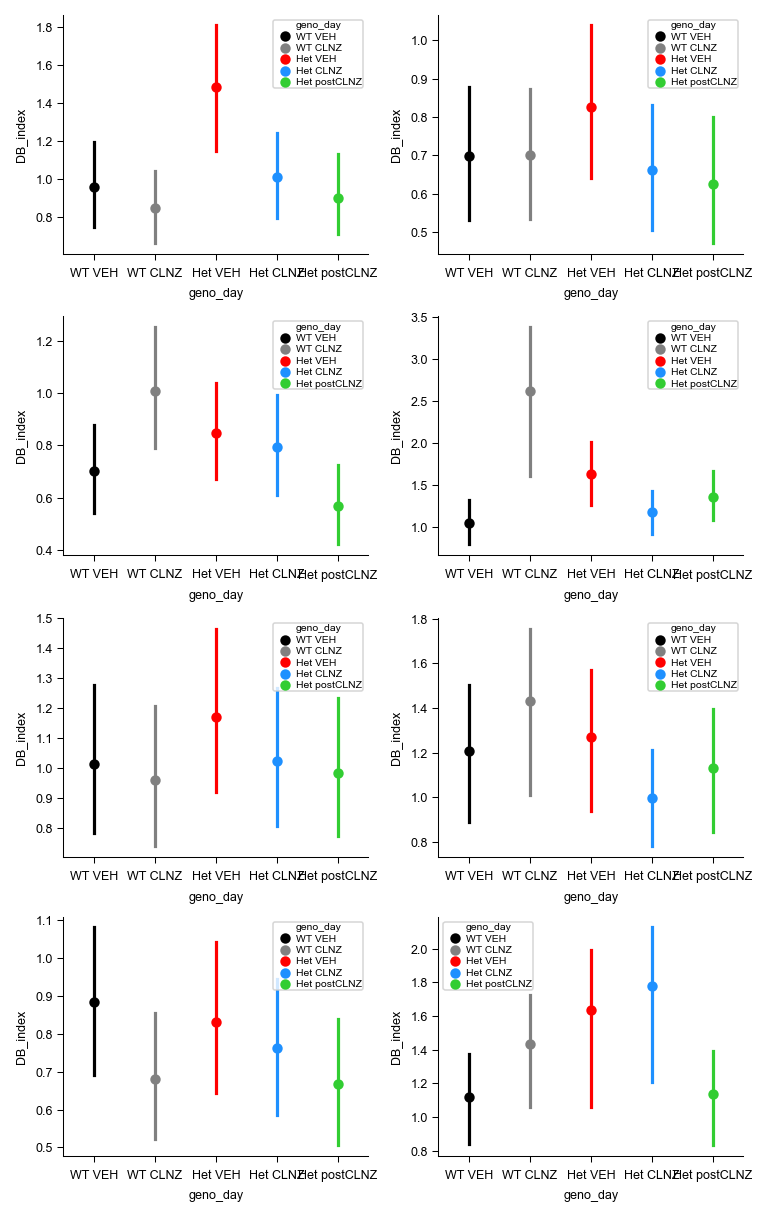

In [74]:

fig_dims = dict(ncols=2,nrows = mean_density.reset_index().comparison.nunique())
fig,ax_array = plt.subplots(**fig_dims, figsize = (2.5*fig_dims['ncols'], 2*fig_dims['nrows']), sharey= False,
                             layout = 'constrained')
#iterate over comparisons
for c, comparison in enumerate(mean_density.reset_index().comparison.unique()):
    comparison_df =score_df.loc[comparison,:]
    ensemble_subset = list(set(comparison_df.index.get_level_values('ensemble')))
    for e,ensemble in enumerate(ensemble_subset): #iterate over ensembles
        plot_score =comparison_df.loc[ensemble,:]
        
        plot_ax = ax_array[c,e]
        plot_params = dict(data = plot_score, x = 'geno_day', y =score_type,
                           order = geno_order_w_WT_CLNZ, **format_no_eb_w_WT_CLNZ,)# palette = color_list, order = geno_order, hue_order = geno_order,  hue = 'geno_day')
        sc = sns.pointplot(ax =plot_ax, errorbar = ('pi',75),dodge = False, **plot_params)
        # plot_ax.get_legend().remove()    
        ax_title = f"{ensemble.replace("_", " ")} ensemble:\n{comparison.replace("_", " ")} latent space\ncluster {score_type} (75ile PI)"

In [75]:
def return_winsorized_data(data:np.array,bounds = [20,80]):
    percentile_lim =  [np.percentile(data, bounds[0]), np.percentile(data, bounds[1])]
    data_winsor = data.copy()
    data_winsor[data_winsor < percentile_lim[0]] = percentile_lim[0]
    data_winsor[data_winsor > percentile_lim[1]] = percentile_lim[1]
    return data_winsor

In [76]:
comparison_df

,model_run,DB_index,n_epochs,final_loss,geno_day,lossDelta,class_1_mean,class_2_mean
ensemble,,,,,,,,
Early_IA_Correct,0,0.680892,50,0.062299,WT VEH,0.0642,0.1253,0.0465
Early_IA_Correct,1,0.929763,50,0.062354,WT VEH,0.0663,0.1256,0.0462
Early_IA_Correct,2,0.927431,50,0.062624,WT VEH,0.0659,0.1257,0.0470
Early_IA_Correct,3,0.872266,50,0.063303,WT VEH,0.0654,0.1270,0.0478
Early_IA_Correct,4,0.819451,50,0.063191,WT VEH,0.0571,0.1279,0.0474
...,...,...,...,...,...,...,...,...
Late_IA,995,0.662648,50,0.074943,Het postCLNZ,0.0731,0.0862,0.1370
Late_IA,996,1.285270,50,0.074573,Het postCLNZ,0.0719,0.0871,0.1333
Late_IA,997,1.219843,50,0.074646,Het postCLNZ,0.0690,0.0876,0.1335


###  Figure- Cluster density in latent space subsets

In [77]:
csv_folder_most_recent =output_folder+f"most_recent_analysis_CSV_storage/"
csv_folder_current_run =output_folder+f"analysis_CSV_storage_{date_tag}/" 
#make current folder 
make_folder( csv_folder_most_recent)
make_folder( csv_folder_current_run)

The folder 'G:\My Drive\Colab notebooks\lightning_autoencoder/output/most_recent_analysis_CSV_storage/' already exists.
The folder 'G:\My Drive\Colab notebooks\lightning_autoencoder/output/analysis_CSV_storage_12_Jul_2025/' already exists.


In [78]:
def plot_db_index_by_ensemble(ax_array, comparison, ensemble_subset, score_df: pd.DataFrame, ylim = [0, 1.5],
                              score_type = 'DB_index',
                              **kwargs):
    """
    Plots ensemble comparison using seaborn pointplot, annotates statistical significance, and appends posthoc results to a provided list.
    Parameters:
    - ensemble_subset (list): List of ensemble identifiers to plot.
    - score_df (pd.DataFrame): DataFrame containing the scores.
    - comparison (str): Identifier for the comparison condition.
    - color_list (list): Colors for plotting.
    - geno_order (list): Order of genotypes for consistent plotting.
    - ax_array (array-like): Array of matplotlib axes to use for subplots.
    - preset_comparison_list (list): Pairs or groups for statistical comparison.
    Returns:
    - - posthoc_list (list): External list to store posthoc result DataFrames. 
    """

    #default args
    fig_suptitle = f"{comparison.replace("_", " ").replace(" v ", " & ")}\n stage activity separation"    # fig_suptitle = f"Separation of activity in\n{comparison.replace("_", " ").replace(" v ", " & ")}stages"
    fig.suptitle(fig_suptitle, fontsize = 6)
    
    posthoc_list= []        
    for e,ensemble in enumerate(ensemble_subset):
        plot_ax = ax_array[e]
        print(store_type)
        plot_params = dict( data = score_df.loc[(comparison,ensemble),:], x = 'geno_day', y =score_type, 
                           palette = color_list, order = geno_order, hue_order = geno_order,  hue = 'geno_day')
        sc = sns.pointplot(ax =plot_ax, errorbar = ('pi',75),dodge = False, **plot_params,**kwargs)
        ensemble_name = f"{ensemble.replace("_", " ")} ensemble"
        set_labels(ax =plot_ax, label_dict = {'title': ensemble_name,
                                              'xlabel': 'Genotype-treatment', 
                                              'legend_false': True, 'ylim': ylim})# set_labels(ax, label_dict= {'title': f"Ensemble: {ensemble}\nCluster density {score_type}",'legend_false':True})
        ## plot stat annotate
        posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(plot_ax, plot_params, sc, preset_comparison_list,
                                                               test_name = 'cohen_d',ax_var_is_hue=True,detect_error_bar = True).assign(comparison=comparison_name)
        plot_sig_bars_w_comp_df_tight(plot_ax, posthoc_df[posthoc_df['pvalue'] < 0.05], tight_offset = 0.03,offset_constant=0.02) 
        set_pointplot_edgecolor(plot_ax)
        posthoc_list.append(posthoc_df)
        #wrap xticks
        plot_ax.set_xticklabels([x.get_text().replace(" ", "\n") for x in plot_ax.get_xticklabels()])
    return posthoc_list

def plot_db_index_geno_dodge(plot_ax, 
                            comparison,
                            ensemble_subset,
                            score_df: pd.DataFrame,
                            add_legend = False,
                            ylim:list = [0, 1.5],
                            score_type = 'DB_index',
                            geno_plot = geno_order,
                            **kwargs):
    """
    Plots ensemble comparison using seaborn pointplot, annotates statistical significance, and appends posthoc results to a provided list.
    Dodges within geno 
    Parameters:
    - ensemble_subset (list): List of ensemble identifiers to plot.
    - score_df (pd.DataFrame): DataFrame containing the scores.
    - comparison (str): Identifier for the comparison condition.
    - color_list (list): Colors for plotting.
    - geno_order (list): Order of genotypes for consistent plotting.
    - ax_array (array-like): Array of matplotlib axes to use for subplots.
    - preset_comparison_list (list): Pairs or groups for statistical comparison.
    Returns:
    - - posthoc_list (list): External list to store posthoc result DataFrames. 
    """
    #main fig
    default_plot_setting = dict(errwidth = 1.25,dodge = 0.45,errorbar = ('pi',75))
    plot_aesthetic = {**kwargs, **{k:v for k,v in default_plot_setting.items() if k not in kwargs}}
    
    plot_params = dict( data = score_df.reset_index("ensemble").loc[comparison,:], 
                       x = 'ensemble', y =score_type, 
                       linestyles= 'none',
                       order = ensemble_subset,  
                      **plot_aesthetic,
                        **{True:geno_order_w_WT_CLNZ_no_eb, False:geno_color_dict_no_errorbar}["WT CLNZ" in geno_plot])
    
    sc = sns.pointplot(ax =plot_ax, **plot_params)
    #ax decorators
    fig_suptitle = f"{comparison.replace('_', ' ').replace(' v ', ' & ')}\n stage activity separation"
    set_labels(ax =plot_ax, label_dict = {'title': fig_suptitle,
                                          'xlabel': 'Cell Ensemble',
                                          'ylabel': 'Davies-Bouldin Index',
                                          'legend_false': False,
                                          'ylim': ylim})# set_labels(ax, label_dict= {'title': f"Ensemble: {ensemble}\nCluster density {score_type}",'legend_false':True})
    set_pointplot_edgecolor(plot_ax)
    ## plot stat annotate
     #NEW- alternate what comparison list to use based on if WT-CLNZ in hue_order or not
    if "WT CLNZ" in plot_params['hue_order']:
        print(f"switching posthoc comparison to include WT CLNZ")
        comparison_list = comparison_list_w_WT_CLNZ
    else:
        comparison_list = preset_comparison_list
    posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(plot_ax, plot_params, 
                                                           sc, comparison_list,
                                                           test_name = 'cohen_d',ax_var_is_hue=False,
                                                           detect_error_bar = True,plot_type='pointplot').assign(comparison=comparison_name)
    plot_sig_bars_w_comp_df_tight(plot_ax, posthoc_df[posthoc_df['pvalue'] < 0.05], tight_offset = 0.02,offset_constant=0.01) 
    #wrap xticks
    add_xtick_color_boxes(plot_ax, ensemble_subset, stage_palette_dict)
    plot_ax.set_xticklabels(add_spaces_linebreak_to_stage_ticks(plot_ax.get_xticklabels()))
     
    if add_legend:
        hand, labs =plot_ax.get_legend_handles_labels() #pull legend from final PCA object and delete it
        plt.gcf().legend(hand, labs, bbox_to_anchor=(0.55, .975),loc = 'lower center', ncols = 4, frameon = False, title =None, **{
            'labelspacing': 0.0,
            'markerscale': 1,
            'borderpad': 0.0,
            'columnspacing': 0.0,
            'handletextpad': 0.0})
               #markerscale=1,fontsize = 5, columnspacing=0.05,labelspacing=0.2,borderpad = 0.1,handletextpad=0.1)

    return posthoc_df

#### Latent space-IA v RS Correct 

In [79]:
latent_embed_sample = embed_record

In [80]:
##set latent space shared variables
compared_col = 'classes_decoded'
ens_col = 'ensemble'

[None, None]

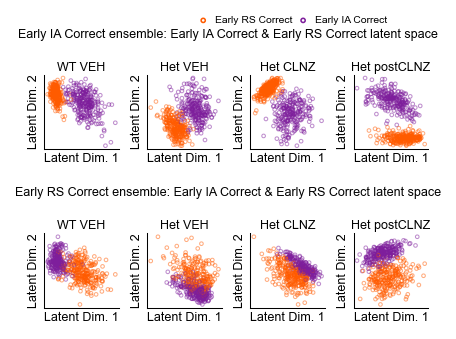

In [81]:
plot_df = latent_embed_sample.rename({'geno_day': 'geno'},axis = 1)
comparison = 'Early_IA_Correct_v_Early_RS_Correct'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
## make figure
latent_space_figsize = (2.75,2)
latent_space_gridspec = dict(wspace = 0.1, hspace = 0.2)
fig,ax_array = plt.subplots(nrows=len(ensemble_subset),ncols = len(geno_order), figsize = latent_space_figsize,
                            layout = 'constrained', gridspec_kw = latent_space_gridspec)
plot_class_scatter_in_latent(fig, ax_array, df_comparison, compared_col, ens_col, ensemble_subset, comparison, make_legend = True)
# ##save fig
fig_name = f"Autoencoder projection- latent space- {comparison} ens"
# save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
[fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]
# 6, filetypes_to_save = ['png','svg'])

Saved 6_Autoencoder Early_IA_Correct_v_Early_RS_Correct DB index by ensembles_posthoc cohen d_12_Jul_2025.csv to G:\My Drive\Colab notebooks\lightning_autoencoder/output/most_recent_analysis_CSV_storage/
Saved 6_Autoencoder Early_IA_Correct_v_Early_RS_Correct DB index by ensembles_posthoc cohen d_12_Jul_2025.csv to G:\My Drive\Colab notebooks\lightning_autoencoder/output/analysis_CSV_storage_12_Jul_2025/
Output saved to G:\My Drive\Colab notebooks\lightning_autoencoder/output/analysis_CSV_storage_12_Jul_2025/6_Autoencoder Early_IA_Correct_v_Early_RS_Correct DB index by ensembles_posthoc_results_text_12_Jul_2025.txt
Output saved to G:\My Drive\Colab notebooks\lightning_autoencoder/output/most_recent_analysis_CSV_storage/6_Autoencoder Early_IA_Correct_v_Early_RS_Correct DB index by ensembles_posthoc_results_text_12_Jul_2025.txt


[None, None]

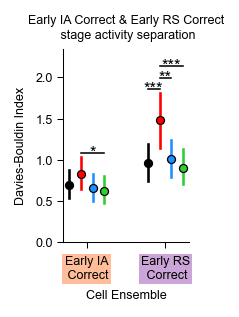

In [82]:
##subfig 2: DB index
comparison = 'Early_IA_Correct_v_Early_RS_Correct'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
db_index_fig_size = (1.25,2.)
fig, plot_ax = plt.subplots(nrows=1,ncols =1,figsize = db_index_fig_size,layout = 'constrained')
## function for plotting DB index for ensemble subset
posthoc_df= plot_db_index_geno_dodge(plot_ax, comparison, ensemble_subset, score_df,ylim = [0, 2.35],scale = 1.0, dodge = 0.45)
##save fig
fig_name = f"Autoencoder {comparison} DB index by ensembles"
#save posthoc CSV
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="6",fig_name,csv_folder_most_recent, csv_folder_current_run, csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")
[fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]
# 6, filetypes_to_save = ['png','svg'])

#### latent space- IA v RS Error

[None, None]

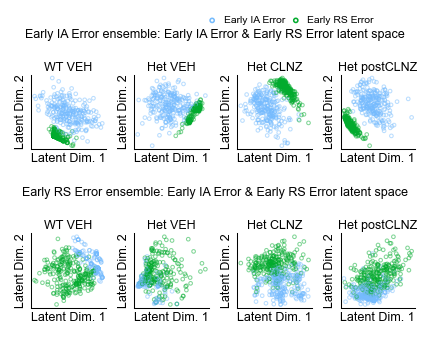

In [83]:
## get df of interest
comparison = 'Early_IA_Error_v_Early_RS_Error'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
## make figure
fig,ax_array = plt.subplots(nrows=len(ensemble_subset),ncols = len(geno_order), figsize = latent_space_figsize,
                            layout = 'constrained', gridspec_kw = latent_space_gridspec)
plot_class_scatter_in_latent(fig, ax_array, df_comparison, compared_col, ens_col, ensemble_subset, comparison, make_legend = True)
##save fig
fig_name = f"Autoencoder projection- latent space- {comparison} ens"
# save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
[fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]


Saved 5_Autoencoder Early_IA_Error_v_Early_RS_Error DB index by ensembles_posthoc cohen d_12_Jul_2025.csv to G:\My Drive\Colab notebooks\lightning_autoencoder/output/most_recent_analysis_CSV_storage/
Saved 5_Autoencoder Early_IA_Error_v_Early_RS_Error DB index by ensembles_posthoc cohen d_12_Jul_2025.csv to G:\My Drive\Colab notebooks\lightning_autoencoder/output/analysis_CSV_storage_12_Jul_2025/
Output saved to G:\My Drive\Colab notebooks\lightning_autoencoder/output/analysis_CSV_storage_12_Jul_2025/5_Autoencoder Early_IA_Error_v_Early_RS_Error DB index by ensembles_posthoc_results_text_12_Jul_2025.txt
Output saved to G:\My Drive\Colab notebooks\lightning_autoencoder/output/most_recent_analysis_CSV_storage/5_Autoencoder Early_IA_Error_v_Early_RS_Error DB index by ensembles_posthoc_results_text_12_Jul_2025.txt


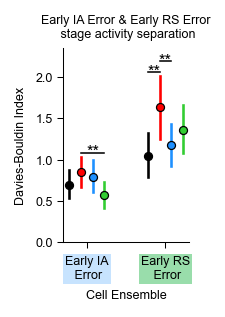

In [84]:
comparison = 'Early_IA_Error_v_Early_RS_Error'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()

fig, plot_ax = plt.subplots(nrows=1,ncols =1,figsize =db_index_fig_size,layout = 'constrained')
## function for plotting DB index for ensemble subset
posthoc_df= plot_db_index_geno_dodge(plot_ax, comparison, ensemble_subset, score_df,ylim = [0, 2.35],scale = 1.0)
##save fig
fig_name = f"Autoencoder {comparison} DB index by ensembles"
# save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
[fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]
#save posthoc CSV
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="5",fig_name,csv_folder_most_recent, csv_folder_current_run, csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")

#### latent space- Late IA v RS Correct

[None, None]

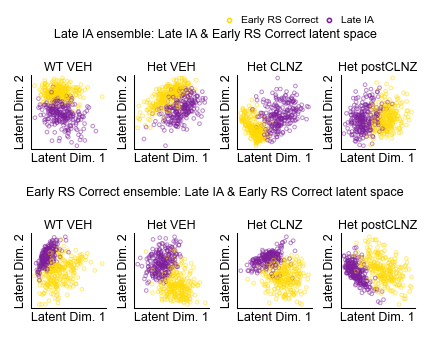

In [85]:
## get df of interest
# plot_df = latent_embed_sample
comparison = 'Late_IA_v_Early_RS_Correct'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
## make figure
fig,ax_array = plt.subplots(nrows=len(ensemble_subset),ncols = len(geno_order), figsize = latent_space_figsize,
                            layout = 'constrained', gridspec_kw = latent_space_gridspec)
plot_class_scatter_in_latent(fig, ax_array, df_comparison, compared_col, ens_col, ensemble_subset, comparison, make_legend = True) ##save fig
##save fig
fig_name = f"Autoencoder projection- latent space- {comparison} ens"
# save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
[fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]


Saved 7_Autoencoder Late_IA_v_Early_RS_Correct DB index by ensembles_posthoc cohen d_12_Jul_2025.csv to G:\My Drive\Colab notebooks\lightning_autoencoder/output/most_recent_analysis_CSV_storage/
Saved 7_Autoencoder Late_IA_v_Early_RS_Correct DB index by ensembles_posthoc cohen d_12_Jul_2025.csv to G:\My Drive\Colab notebooks\lightning_autoencoder/output/analysis_CSV_storage_12_Jul_2025/
Output saved to G:\My Drive\Colab notebooks\lightning_autoencoder/output/analysis_CSV_storage_12_Jul_2025/7_Autoencoder Late_IA_v_Early_RS_Correct DB index by ensembles_posthoc_results_text_12_Jul_2025.txt
Output saved to G:\My Drive\Colab notebooks\lightning_autoencoder/output/most_recent_analysis_CSV_storage/7_Autoencoder Late_IA_v_Early_RS_Correct DB index by ensembles_posthoc_results_text_12_Jul_2025.txt


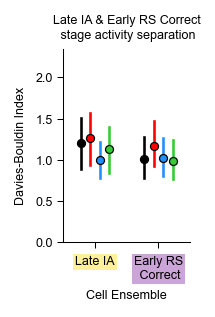

In [86]:
## get df of interest
# plot_df = latent_embed_sample
comparison = 'Late_IA_v_Early_RS_Correct'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
fig, plot_ax = plt.subplots(nrows=1,ncols =1,figsize = db_index_fig_size,layout = 'constrained')
## function for plotting DB index for ensemble subset
posthoc_df= plot_db_index_geno_dodge(plot_ax, comparison, ensemble_subset, score_df,ylim = [0, 2.35],scale = 1.0)
##save fig
fig_name = f"Autoencoder {comparison} DB index by ensembles"
# save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
[fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]
#save posthoc CSV
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="7",fig_name,csv_folder_most_recent, csv_folder_current_run,csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")

[None, None]

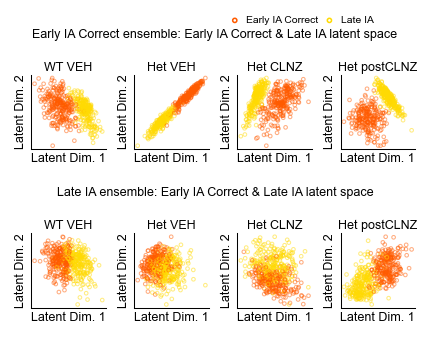

In [87]:
## get df of interest
# plot_df = latent_embed_sample
comparison = 'Early_IA_Correct_v_Late_IA'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
## make figure
fig,ax_array = plt.subplots(nrows=len(ensemble_subset),ncols = len(geno_order), figsize = latent_space_figsize,
                            layout = 'constrained', gridspec_kw = latent_space_gridspec)
plot_class_scatter_in_latent(fig, ax_array, df_comparison, compared_col, ens_col, ensemble_subset, comparison, make_legend = True)
##save fig
fig_name = f"Autoencoder projection- latent space- {comparison} ens"
# save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
[fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]


Saved 7_Autoencoder Early_IA_Correct_v_Late_IA DB index by ensembles_posthoc cohen d_12_Jul_2025.csv to G:\My Drive\Colab notebooks\lightning_autoencoder/output/most_recent_analysis_CSV_storage/
Saved 7_Autoencoder Early_IA_Correct_v_Late_IA DB index by ensembles_posthoc cohen d_12_Jul_2025.csv to G:\My Drive\Colab notebooks\lightning_autoencoder/output/analysis_CSV_storage_12_Jul_2025/
Output saved to G:\My Drive\Colab notebooks\lightning_autoencoder/output/analysis_CSV_storage_12_Jul_2025/7_Autoencoder Early_IA_Correct_v_Late_IA DB index by ensembles_posthoc_results_text_12_Jul_2025.txt
Output saved to G:\My Drive\Colab notebooks\lightning_autoencoder/output/most_recent_analysis_CSV_storage/7_Autoencoder Early_IA_Correct_v_Late_IA DB index by ensembles_posthoc_results_text_12_Jul_2025.txt


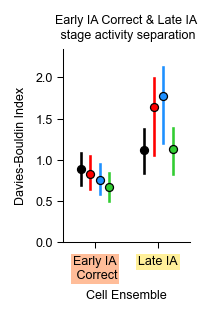

In [88]:
# plot_df = latent_embed_sample
comparison = 'Early_IA_Correct_v_Late_IA'## get df of interest
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
## function for plotting DB index for ensemble subset##
fig, plot_ax = plt.subplots(nrows=1,ncols =1,figsize = db_index_fig_size,layout = 'constrained')
posthoc_df= plot_db_index_geno_dodge(plot_ax, comparison, ensemble_subset, score_df,ylim = [0, 2.35],scale = 1.0)
##save fig
fig_name = f"Autoencoder {comparison} DB index by ensembles"
# save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
[fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]

#save posthoc CSV
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="7",fig_name,csv_folder_most_recent, csv_folder_current_run, csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")
   

## Supplement DB index plots

#### Latent space-IA v RS Correct 

In [89]:
latent_embed_sample = embed_record

##set latent space shared variables
compared_col = 'classes_decoded'
ens_col = 'ensemble'

In [90]:
supp_figure_prefix = "supp_"

switching posthoc comparison to include WT CLNZ
Saved 6_s_supp_Autoencoder Early_IA_Correct_v_Early_RS_Correct DB index by ensembles_posthoc cohen d_12_Jul_2025.csv to G:\My Drive\Colab notebooks\lightning_autoencoder/output/most_recent_analysis_CSV_storage/
Saved 6_s_supp_Autoencoder Early_IA_Correct_v_Early_RS_Correct DB index by ensembles_posthoc cohen d_12_Jul_2025.csv to G:\My Drive\Colab notebooks\lightning_autoencoder/output/analysis_CSV_storage_12_Jul_2025/
Output saved to G:\My Drive\Colab notebooks\lightning_autoencoder/output/analysis_CSV_storage_12_Jul_2025/6_s_supp_Autoencoder Early_IA_Correct_v_Early_RS_Correct DB index by ensembles_posthoc_results_text_12_Jul_2025.txt
Output saved to G:\My Drive\Colab notebooks\lightning_autoencoder/output/most_recent_analysis_CSV_storage/6_s_supp_Autoencoder Early_IA_Correct_v_Early_RS_Correct DB index by ensembles_posthoc_results_text_12_Jul_2025.txt


[None, None]

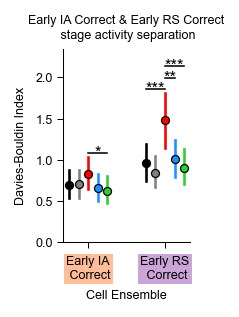

In [91]:
##subfig 2: DB index
comparison = 'Early_IA_Correct_v_Early_RS_Correct'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
db_index_fig_size = (1.25,2.)
fig, plot_ax = plt.subplots(nrows=1,ncols =1,figsize = db_index_fig_size,layout = 'constrained')
## function for plotting DB index for ensemble subset
posthoc_df= plot_db_index_geno_dodge(plot_ax, comparison, ensemble_subset, score_df, geno_plot = geno_order_w_WT_CLNZ, ylim = [0, 2.35],scale = 1.0,dodge = 0.5)
##save fig
fig_name = supp_figure_prefix+ f"Autoencoder {comparison} DB index by ensembles"
#save posthoc CSV
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="6_s",fig_name,csv_folder_most_recent, csv_folder_current_run, csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")
[fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]
# 6, filetypes_to_save = ['png','svg'])

#### latent space- IA v RS Error

In [92]:
comparison_list_w_WT_CLNZ

[('WT VEH', 'WT CLNZ'),
 ('WT VEH', 'Het VEH'),
 ('Het VEH', 'Het CLNZ'),
 ('Het VEH', 'Het postCLNZ')]

In [93]:
preset_comparison_list

[('WT VEH', 'Het VEH'), ('Het VEH', 'Het CLNZ'), ('Het VEH', 'Het postCLNZ')]

switching posthoc comparison to include WT CLNZ
Saved 5_s_supp_Autoencoder Early_IA_Error_v_Early_RS_Error DB index by ensembles_posthoc cohen d_12_Jul_2025.csv to G:\My Drive\Colab notebooks\lightning_autoencoder/output/most_recent_analysis_CSV_storage/
Saved 5_s_supp_Autoencoder Early_IA_Error_v_Early_RS_Error DB index by ensembles_posthoc cohen d_12_Jul_2025.csv to G:\My Drive\Colab notebooks\lightning_autoencoder/output/analysis_CSV_storage_12_Jul_2025/
Output saved to G:\My Drive\Colab notebooks\lightning_autoencoder/output/analysis_CSV_storage_12_Jul_2025/5_s_supp_Autoencoder Early_IA_Error_v_Early_RS_Error DB index by ensembles_posthoc_results_text_12_Jul_2025.txt
Output saved to G:\My Drive\Colab notebooks\lightning_autoencoder/output/most_recent_analysis_CSV_storage/5_s_supp_Autoencoder Early_IA_Error_v_Early_RS_Error DB index by ensembles_posthoc_results_text_12_Jul_2025.txt


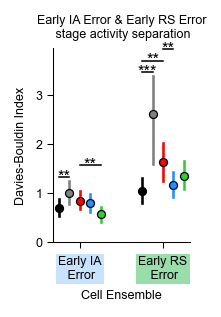

In [94]:
comparison = 'Early_IA_Error_v_Early_RS_Error'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()

fig, plot_ax = plt.subplots(nrows=1,ncols =1,figsize =db_index_fig_size,layout = 'constrained')
## function for plotting DB index for ensemble subset
posthoc_df= plot_db_index_geno_dodge(plot_ax, comparison, ensemble_subset, score_df,geno_plot = geno_order_w_WT_CLNZ,
                                     ylim = [0, 3.95],scale = 1.0,dodge = 0.5)
##save fig
fig_name =supp_figure_prefix+  f"Autoencoder {comparison} DB index by ensembles"
# save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
[fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]
#save posthoc CSV
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="5_s",fig_name,csv_folder_most_recent, csv_folder_current_run, csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")

#### latent space- Late IA v RS Correct

switching posthoc comparison to include WT CLNZ
Saved 7_s_supp_Autoencoder Late_IA_v_Early_RS_Correct DB index by ensembles_posthoc cohen d_12_Jul_2025.csv to G:\My Drive\Colab notebooks\lightning_autoencoder/output/most_recent_analysis_CSV_storage/
Saved 7_s_supp_Autoencoder Late_IA_v_Early_RS_Correct DB index by ensembles_posthoc cohen d_12_Jul_2025.csv to G:\My Drive\Colab notebooks\lightning_autoencoder/output/analysis_CSV_storage_12_Jul_2025/
Output saved to G:\My Drive\Colab notebooks\lightning_autoencoder/output/analysis_CSV_storage_12_Jul_2025/7_s_supp_Autoencoder Late_IA_v_Early_RS_Correct DB index by ensembles_posthoc_results_text_12_Jul_2025.txt
Output saved to G:\My Drive\Colab notebooks\lightning_autoencoder/output/most_recent_analysis_CSV_storage/7_s_supp_Autoencoder Late_IA_v_Early_RS_Correct DB index by ensembles_posthoc_results_text_12_Jul_2025.txt


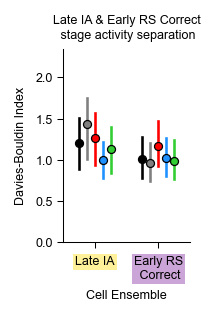

In [95]:
## get df of interest
# plot_df = latent_embed_sample
comparison = 'Late_IA_v_Early_RS_Correct'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
fig, plot_ax = plt.subplots(nrows=1,ncols =1,figsize = db_index_fig_size,layout = 'constrained')
## function for plotting DB index for ensemble subset
posthoc_df= plot_db_index_geno_dodge(plot_ax, comparison, ensemble_subset, score_df,geno_plot = geno_order_w_WT_CLNZ,
                                     ylim = [0, 2.35],scale = 1.0,dodge = 0.5)
##save fig
fig_name =supp_figure_prefix+  f"Autoencoder {comparison} DB index by ensembles"
# save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
[fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]
#save posthoc CSV
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="7_s",fig_name,csv_folder_most_recent, csv_folder_current_run, csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")

switching posthoc comparison to include WT CLNZ
Saved 7_s_supp_Autoencoder Early_IA_Correct_v_Late_IA DB index by ensembles_posthoc cohen d_12_Jul_2025.csv to G:\My Drive\Colab notebooks\lightning_autoencoder/output/most_recent_analysis_CSV_storage/
Saved 7_s_supp_Autoencoder Early_IA_Correct_v_Late_IA DB index by ensembles_posthoc cohen d_12_Jul_2025.csv to G:\My Drive\Colab notebooks\lightning_autoencoder/output/analysis_CSV_storage_12_Jul_2025/
Output saved to G:\My Drive\Colab notebooks\lightning_autoencoder/output/analysis_CSV_storage_12_Jul_2025/7_s_supp_Autoencoder Early_IA_Correct_v_Late_IA DB index by ensembles_posthoc_results_text_12_Jul_2025.txt
Output saved to G:\My Drive\Colab notebooks\lightning_autoencoder/output/most_recent_analysis_CSV_storage/7_s_supp_Autoencoder Early_IA_Correct_v_Late_IA DB index by ensembles_posthoc_results_text_12_Jul_2025.txt


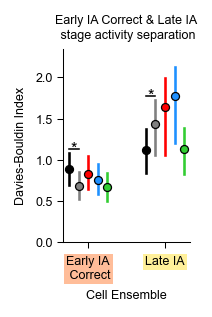

In [96]:
# plot_df = latent_embed_sample
comparison = 'Early_IA_Correct_v_Late_IA'## get df of interest
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
## function for plotting DB index for ensemble subset##
fig, plot_ax = plt.subplots(nrows=1,ncols =1,figsize = db_index_fig_size,layout = 'constrained')
posthoc_df= plot_db_index_geno_dodge(plot_ax, comparison, ensemble_subset, score_df,
                                     geno_plot = geno_order_w_WT_CLNZ,
                                     ylim = [0, 2.35],scale = 1.0,dodge = 0.5)
##save fig
fig_name =supp_figure_prefix+  f"Autoencoder {comparison} DB index by ensembles"
# save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
[fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]

#save posthoc CSV
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="7_s",fig_name,csv_folder_most_recent, csv_folder_current_run, csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")
   

In [97]:
os.getcwd()

'G:\\My Drive\\Colab notebooks\\lightning_autoencoder'